# Final Project Forecasting

Course: Predictive Modelling and Analytics [A]

Group Member:
- xxx (xxx)
- xxx (xxx)
- xxx (xxx)

[Paper reference]()

## Setup

Initializing Global Variables

In [133]:
WINDOW_SIZE = 12 # 12 months (1 year)
FORECAST_WINDOW = 60 # 5 years
REGIONS = ['JBR', 'GSK', 'PMK']

Importing libraries, dependencies and dataset

In [134]:
# libraries and depedencies
import pandas as pd
from pandas import read_csv
from pandas import to_datetime

import numpy as np
from numpy import array

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator

import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

data = read_csv("./Dataset/Data FP PMA-A.csv")
data.head()

,Periode,JBR,GSK,PMK
0,1/1/2004,924674.0,263849.0,930283.0
1,2/1/2004,925009.0,264080.0,931837.0
2,3/1/2004,925057.0,264149.0,931837.0
3,4/1/2004,925095.0,264195.0,931837.0
4,5/1/2004,925105.0,264380.0,932857.0


converting variables to the correct datatype

In [135]:
curr = data.iloc[-1]['Periode'].split('/')
index = []
for i in range(60):
    m = int(curr[0])
    y = int(curr[2])
    if m < 12:
        curr[0] = str(m+1)
    else:
        curr[2] = str(y+1)
        curr[0] = str(1)
    idx = "/".join(curr)
    index.append(idx)
index_forecast = to_datetime(pd.Series(index))
index_forecast

0    2023-07-01
1    2023-08-01
2    2023-09-01
3    2023-10-01
4    2023-11-01
5    2023-12-01
6    2024-01-01
7    2024-02-01
8    2024-03-01
9    2024-04-01
10   2024-05-01
11   2024-06-01
12   2024-07-01
13   2024-08-01
14   2024-09-01
15   2024-10-01
16   2024-11-01
17   2024-12-01
18   2025-01-01
19   2025-02-01
20   2025-03-01
21   2025-04-01
22   2025-05-01
23   2025-06-01
24   2025-07-01
25   2025-08-01
26   2025-09-01
27   2025-10-01
28   2025-11-01
29   2025-12-01
30   2026-01-01
31   2026-02-01
32   2026-03-01
33   2026-04-01
34   2026-05-01
35   2026-06-01
36   2026-07-01
37   2026-08-01
38   2026-09-01
39   2026-10-01
40   2026-11-01
41   2026-12-01
42   2027-01-01
43   2027-02-01
44   2027-03-01
45   2027-04-01
46   2027-05-01
47   2027-06-01
48   2027-07-01
49   2027-08-01
50   2027-09-01
51   2027-10-01
52   2027-11-01
53   2027-12-01
54   2028-01-01
55   2028-02-01
56   2028-03-01
57   2028-04-01
58   2028-05-01
59   2028-06-01
dtype: datetime64[ns]

In [136]:
data['Periode'] = to_datetime(data['Periode'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Periode  234 non-null    datetime64[ns]
 1   JBR      234 non-null    float64       
 2   GSK      234 non-null    float64       
 3   PMK      234 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 7.4 KB


Scaling data

In [137]:
scaler = MinMaxScaler()
for reg in REGIONS:
    data[reg] = scaler.fit_transform(data[reg].values.reshape(-1, 1))
data.head()

,Periode,JBR,GSK,PMK
0,2004-01-01,0.024632,0.000000,0.000000
1,2004-02-01,0.029932,0.000432,0.015600
2,2004-03-01,0.030691,0.000561,0.015600
3,2004-04-01,0.031293,0.000647,0.015600
4,2004-05-01,0.031451,0.000994,0.025839


## Visualization

In [138]:
def visualize(data, var=[], label=''):
    fig, ax = plt.subplots(figsize=(25, 10))
    plt.title(f'Data Rumah Tangga {label}', fontsize=20)

    for v in var:
        plt.plot(data['Periode'], data[v], label=v)
    
    plt.xlim(data['Periode'].min(), data['Periode'].max())
    plt.xlabel('Date', fontsize=15)

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator((4,8,12)))

    ax.xaxis.set_major_formatter(DateFormatter("\n%Y"))
    ax.xaxis.set_minor_formatter(DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

    ax.get_yaxis().get_major_formatter().set_scientific(False)

    plt.legend()  
    plt.show()


In [139]:
def compare_pred_actual(result):
    fig, axs = plt.subplots(len(result), 1, figsize=(10, 15))
    fig.tight_layout(pad=5.0)

    for i, (region, df) in enumerate(result.items()):
        axs[i].plot(df['Predictions'], label='Predictions')
        axs[i].plot(df['Actuals'], label='Actuals')
        axs[i].set_title(f'{region} Predictions vs Actuals')
        axs[i].set_xlabel('Index')
        axs[i].set_ylabel('Values')
        axs[i].get_yaxis().get_major_formatter().set_scientific(False)
        axs[i].legend()

    plt.show()

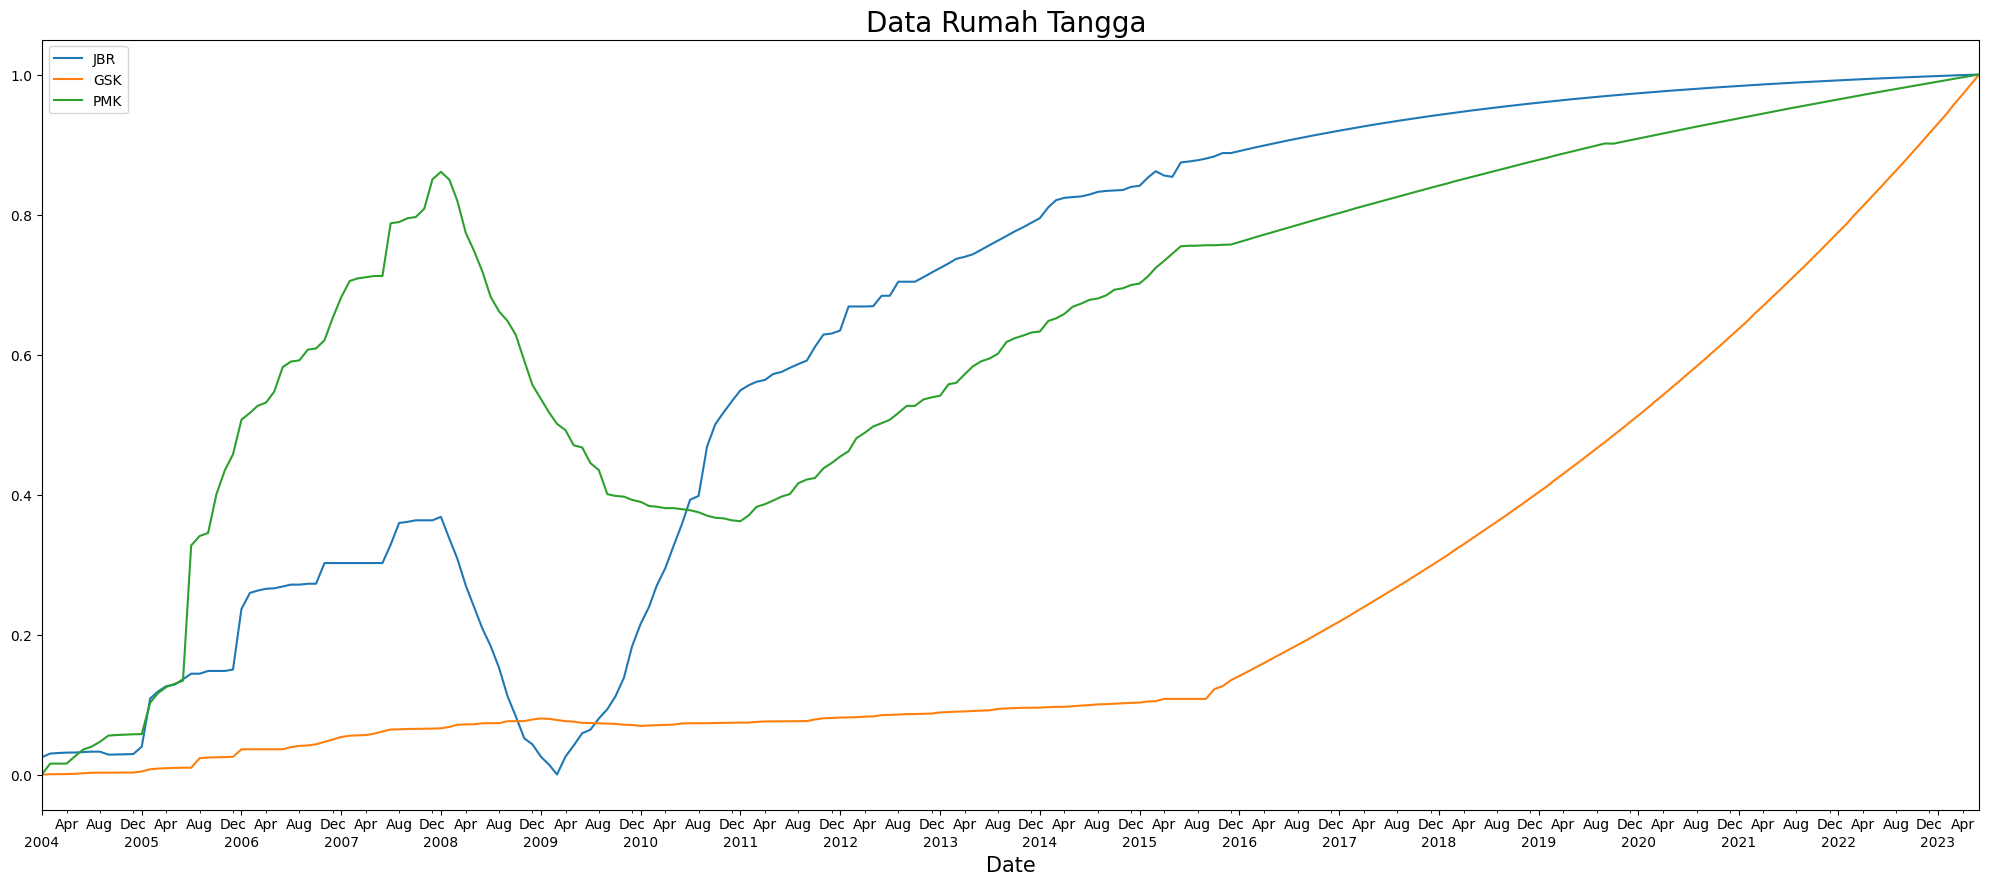

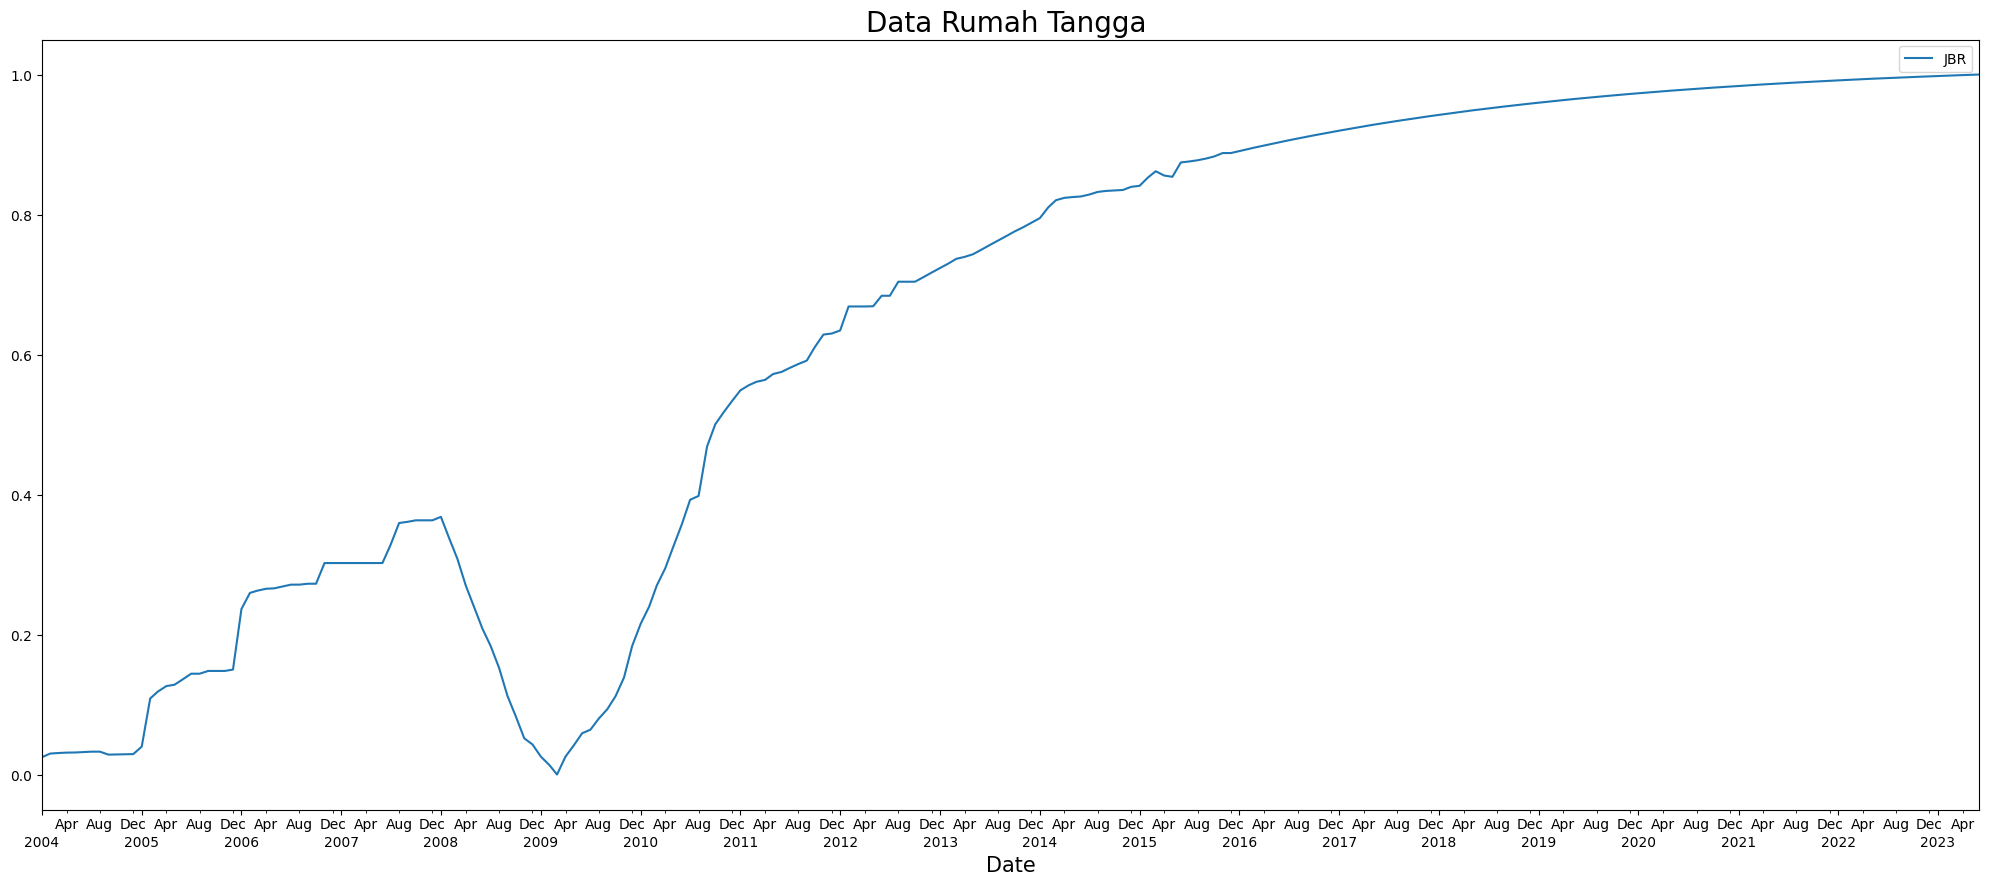

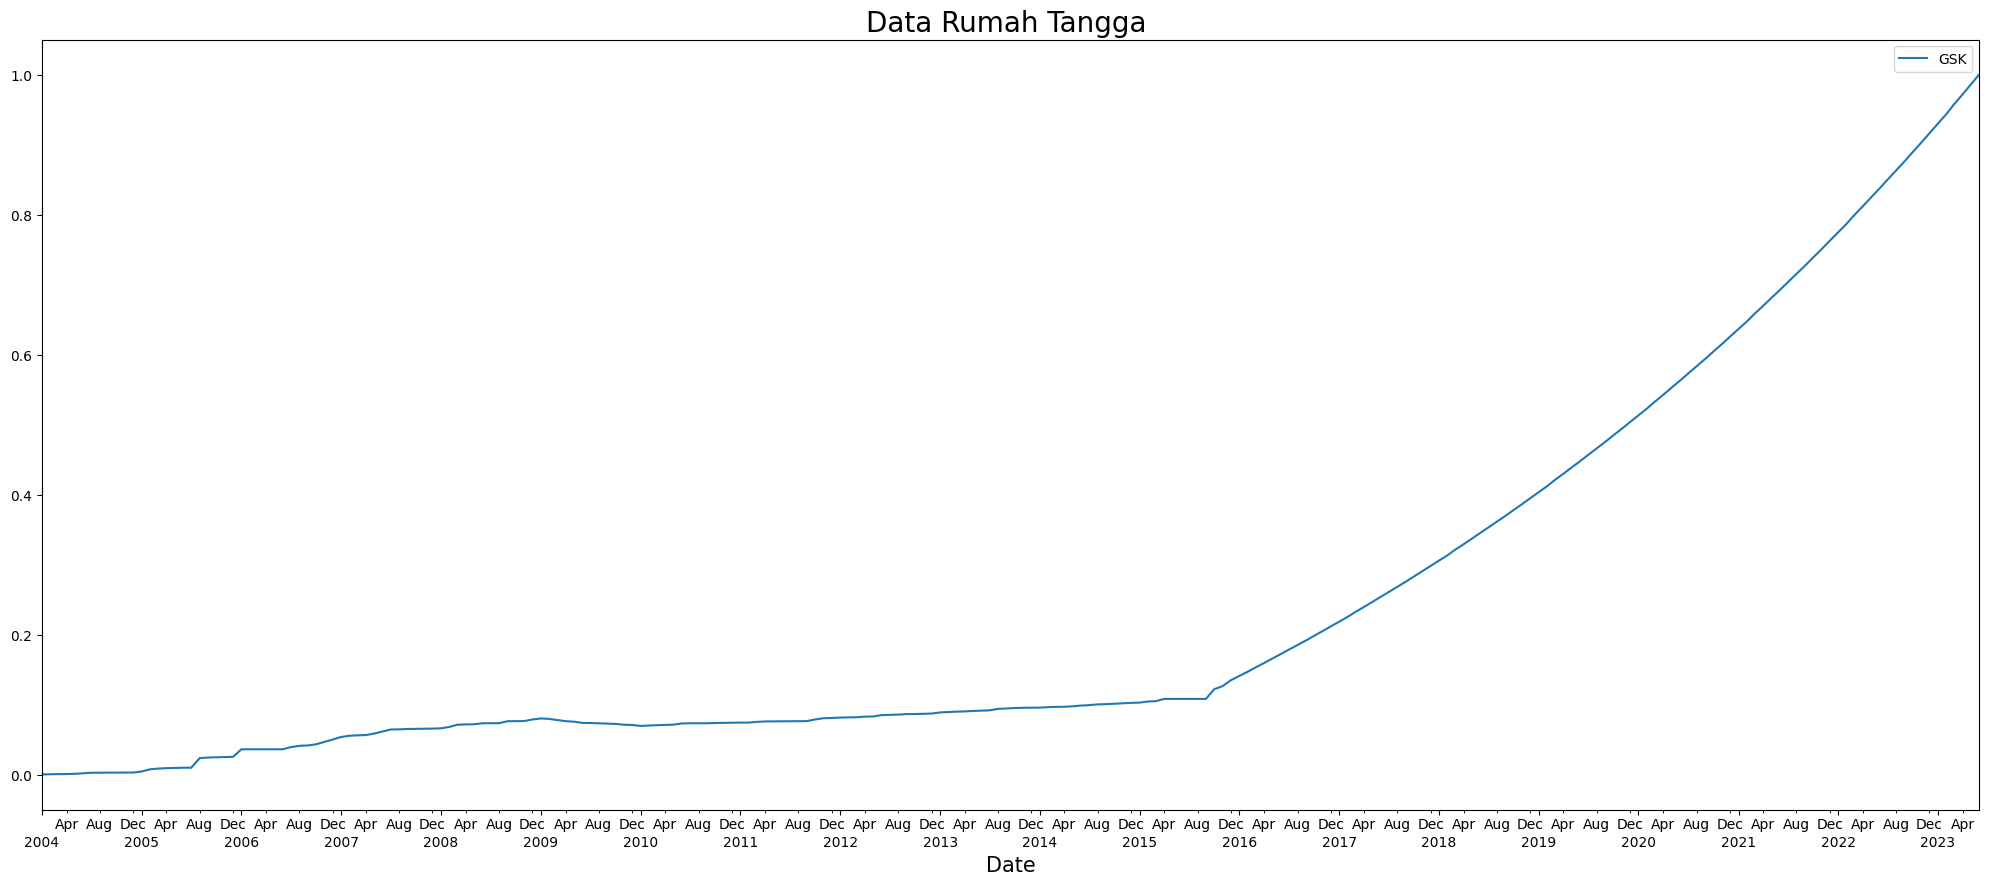

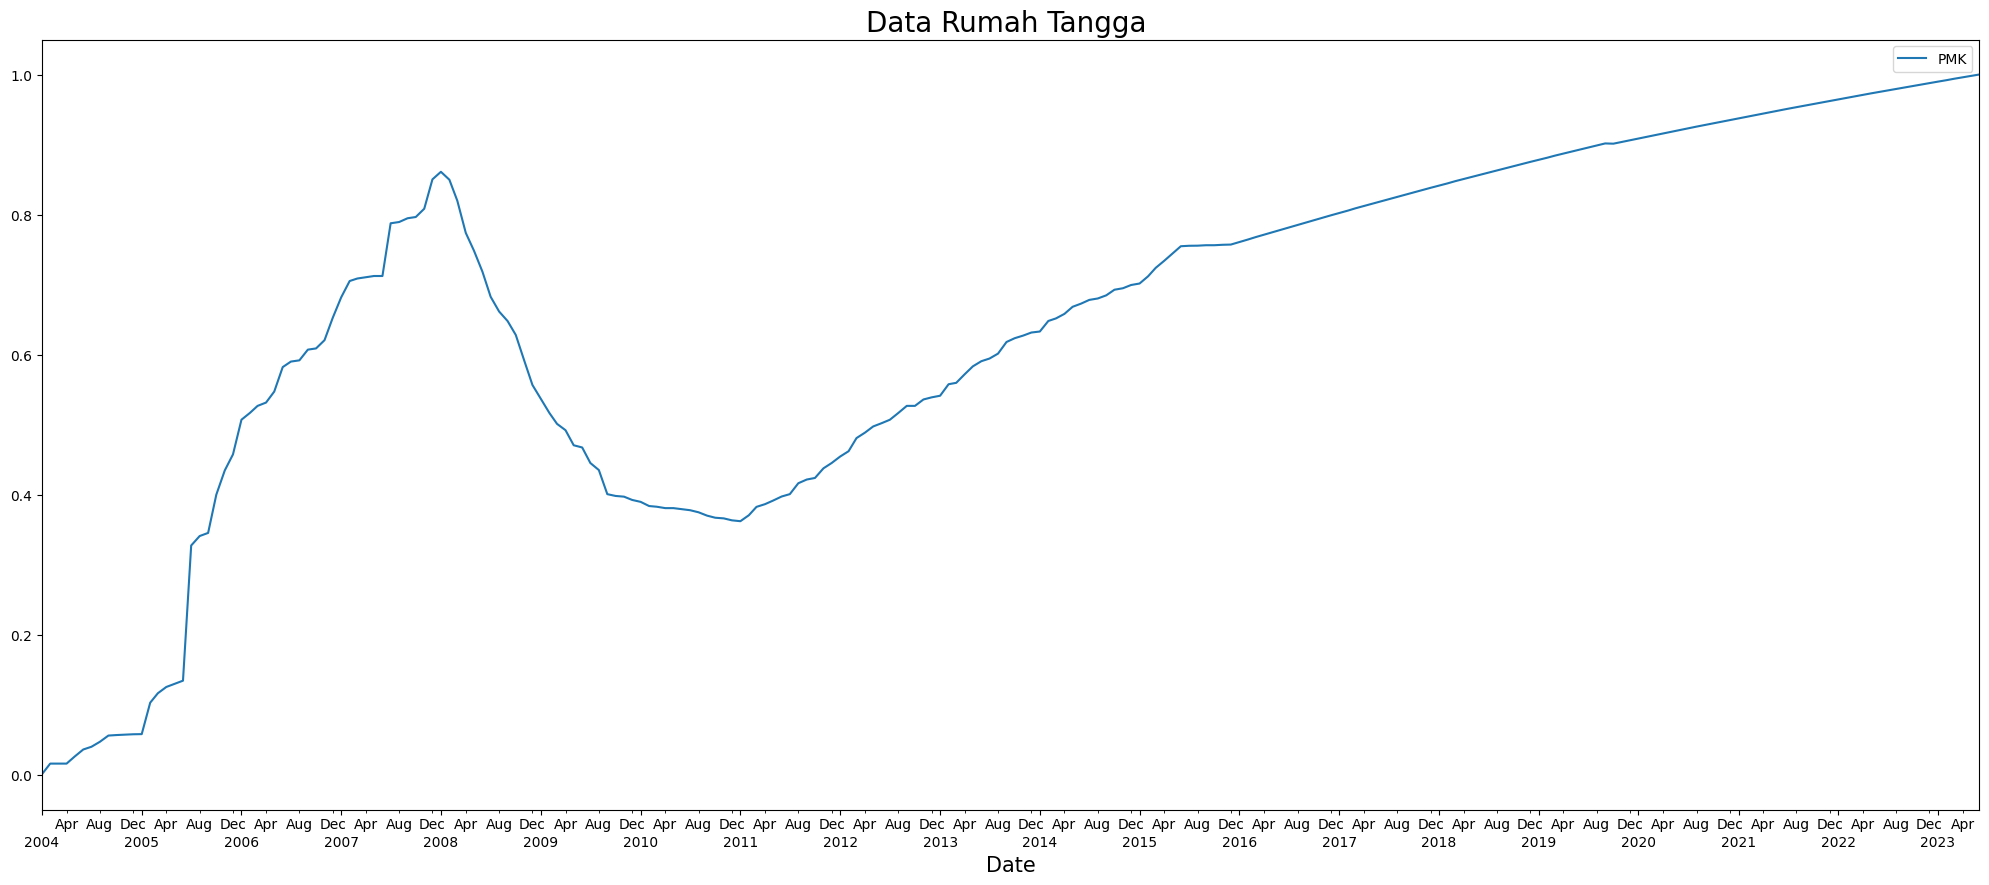

In [140]:
visualize(data, REGIONS)

for reg in REGIONS:
    visualize(data, [reg])

## Building Model

### Data Windows

In [141]:
def dataframe_to_windowed_data(df, window_size):
  df_as_np = df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    x.append(row)
    label = df_as_np[i+window_size]

    y.append(label)
  return np.array(x), np.array(y)

### LSTM

In [142]:
def create_LSTM() -> Sequential:
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(64, activation='relu', input_shape=(WINDOW_SIZE, 1), return_sequences=True))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(LSTM(64, activation='relu'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(8, 'relu'))
    model_LSTM.add(Dense(1, 'linear'))
    model_LSTM.compile(optimizer='adam', loss='mse')
    return model_LSTM

def train_LSTM(train_ratio=0.8) -> dict:
    train_res = {}
    test_res = {}

    for reg in REGIONS:
        x, y = dataframe_to_windowed_data(data[reg], WINDOW_SIZE)
        range_index_train = int(train_ratio * len(x))

        x_train, y_train = x[:range_index_train], y[:range_index_train]
        x_test, y_test = x[range_index_train:], y[range_index_train:]

        model_LSTM = create_LSTM()
        model_LSTM.fit(x_train, y_train, epochs=100, batch_size=2)
        # model_LSTM.save(f'./Models/LSTM_{reg}.keras')

        train_predictions = model_LSTM.predict(x_train).flatten()
        train_results = pd.DataFrame(data={'Predictions': train_predictions, 'Actuals': y_train})
        train_res[reg] = train_results

        predictions_LSTM = model_LSTM.predict(x_test).flatten()
        test_results = pd.DataFrame(data={'Predictions':predictions_LSTM, 'Actuals':y_test})
        test_res[reg] = test_results

    return train_res, test_res

def forecast_LSTM(forecast_window):
    results = {}

    for reg in REGIONS:
        model = create_LSTM()
        x, y = dataframe_to_windowed_data(data[reg], WINDOW_SIZE)
        model.fit(x, y, epochs=100, batch_size=2)
        
        forecast = []
        current_input = y[-WINDOW_SIZE:].reshape((1, WINDOW_SIZE, 1))
        
        for _ in range(forecast_window):
            next_pred = model.predict(current_input)[0, 0]
            forecast.append(next_pred)
            current_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)
        
        forecast = pd.Series(forecast, index=index_forecast)
        results[reg] = forecast
    
    return results

### ARIMA

In [143]:
def create_ARIMA(train_data, I):
    model_ARIMA = auto_arima(train_data, start_p=0, start_q=0,d=I,
                       error_action='warn',trace=True,suppress_warnings=True,
                      stepwise=True,random_state=20,n_fits=50)
    return model_ARIMA

def train_ARIMA(train_ratio=0.8) -> dict:
    results = {}

    for reg in REGIONS:
        train, test = train_test_split(data, train_size=train_ratio, shuffle=False)
        d_val = 0;
        
        train_copy = train[reg].copy()
        while(adfuller(train_copy)[1] > .05):
            print(f'Melakukan differencing data')
            train_copy = train_copy.diff().dropna()
            d_val+=1


        model_ARIMA = create_ARIMA(train[reg], d_val)
        predictions_ARIMA = model_ARIMA.predict(n_periods=len(test))
        predictions_ARIMA = pd.Series((list(train[reg]) + list(predictions_ARIMA)),index=data['Periode'])
        
        pad = [None]*len(train[reg])
        test = pd.Series((pad + list(test[reg])),index=data['Periode'])
        
        results[reg] = pd.DataFrame(data={'Predictions': predictions_ARIMA, 'Actuals': test})

    return results

def forecast_ARIMA(forecast_window):
    results = {}
    for reg in REGIONS:
        d_val = 0;
        train_copy = data[reg].copy()
        while(adfuller(train_copy)[1] > .05):
            print(f'Melakukan differencing data')
            train_copy = train_copy.diff().dropna()
            d_val+=1
        model = create_ARIMA(data[reg],d_val)
        pred = pd.Series(list(model.predict(n_periods=forecast_window)),index=index_forecast)
        pred = round(pred,2)
        results[reg] = pred
    return results

### ARIMA-LSTM

In [144]:
def create_ARIMA_LSTM(ARIMA, LSTM, region) -> pd.DataFrame:
    print(f'Dataset {region}')
    ARIMA_LSTM_df = pd.DataFrame({
        'Actuals': list(data[region].tail(len(LSTM))),
        'ARIMA_predictions': list(ARIMA.tail(len(LSTM))),
        'LSTM_predictions': list(LSTM)
    }, index=data['Periode'].tail(len(LSTM)))

    return ARIMA_LSTM_df

def train_ARIMA_LSTM(ARIMA_LSTM_dataframe) -> dict:
    prediction = []

    LSTM_MAE = mae(ARIMA_LSTM_dataframe['Actuals'],ARIMA_LSTM_dataframe['LSTM_predictions'])
    ARIMA_MAE = mae(ARIMA_LSTM_dataframe['Actuals'],ARIMA_LSTM_dataframe['ARIMA_predictions'])
    LSTM_weight = LSTM_MAE/(LSTM_MAE+ARIMA_MAE)
    ARIMA_weight = ARIMA_MAE/(LSTM_MAE+ARIMA_MAE)

    for row_idx in range(len(ARIMA_LSTM_dataframe)):
        predicted = ARIMA_LSTM_dataframe['ARIMA_predictions'][row_idx]*ARIMA_weight + ARIMA_LSTM_dataframe['LSTM_predictions'][row_idx]*LSTM_weight
        prediction.append(predicted)

    ARIMA_LSTM_dataframe['Predictions'] = prediction
    mae_result = mae(ARIMA_LSTM_dataframe['Predictions'],ARIMA_LSTM_dataframe['Actuals'])
    mape_result = mape(ARIMA_LSTM_dataframe['Predictions'],ARIMA_LSTM_dataframe['Actuals'])
    mse_result = mse(ARIMA_LSTM_dataframe['Predictions'],ARIMA_LSTM_dataframe['Actuals'])
    print(f"MAE = {mae_result}")
    print(f'MAPE = {mape_result}')
    print(f'MSE = {mse_result} \n')
    return ARIMA_LSTM_dataframe,LSTM_weight,ARIMA_weight
    
def forecast_ARIMA_LSTM(LSTM_weight:dict, ARIMA_weight:dict, ARIMA_forecast:dict, LSTM_forecast:dict):
    final_forecast = {}
    for reg in REGIONS:
        ARIMA_list = list(ARIMA_forecast[reg])
        LSTM_list = list(LSTM_forecast[reg])
        forecasted = []
        for i in range(FORECAST_WINDOW):
            forecasted.append(ARIMA_list[i]*ARIMA_weight[reg] + LSTM_list[i]*LSTM_weight[reg])
        final_forecast[reg] = pd.Series(forecasted,index=index_forecast)
    return final_forecast

## Training and Forecast Scenarios

1. 80% Train - 20% Test
2. 70% Train - 30 % Test
3. 60% Train - 40 % Test

### 1. 80% Train 20% Test

#### LSTM

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 533265842176.0000
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 59174862848.0000
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 101652032.0000
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4843088.0000
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4815187.5000
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5772698.0000
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7300109.5000
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6503986.0000
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6619027.0000
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5567229.0000
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6088683.5000
Epoch 12/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6569541.5000
Epoch 13/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5472912.5000
Epoch 14/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

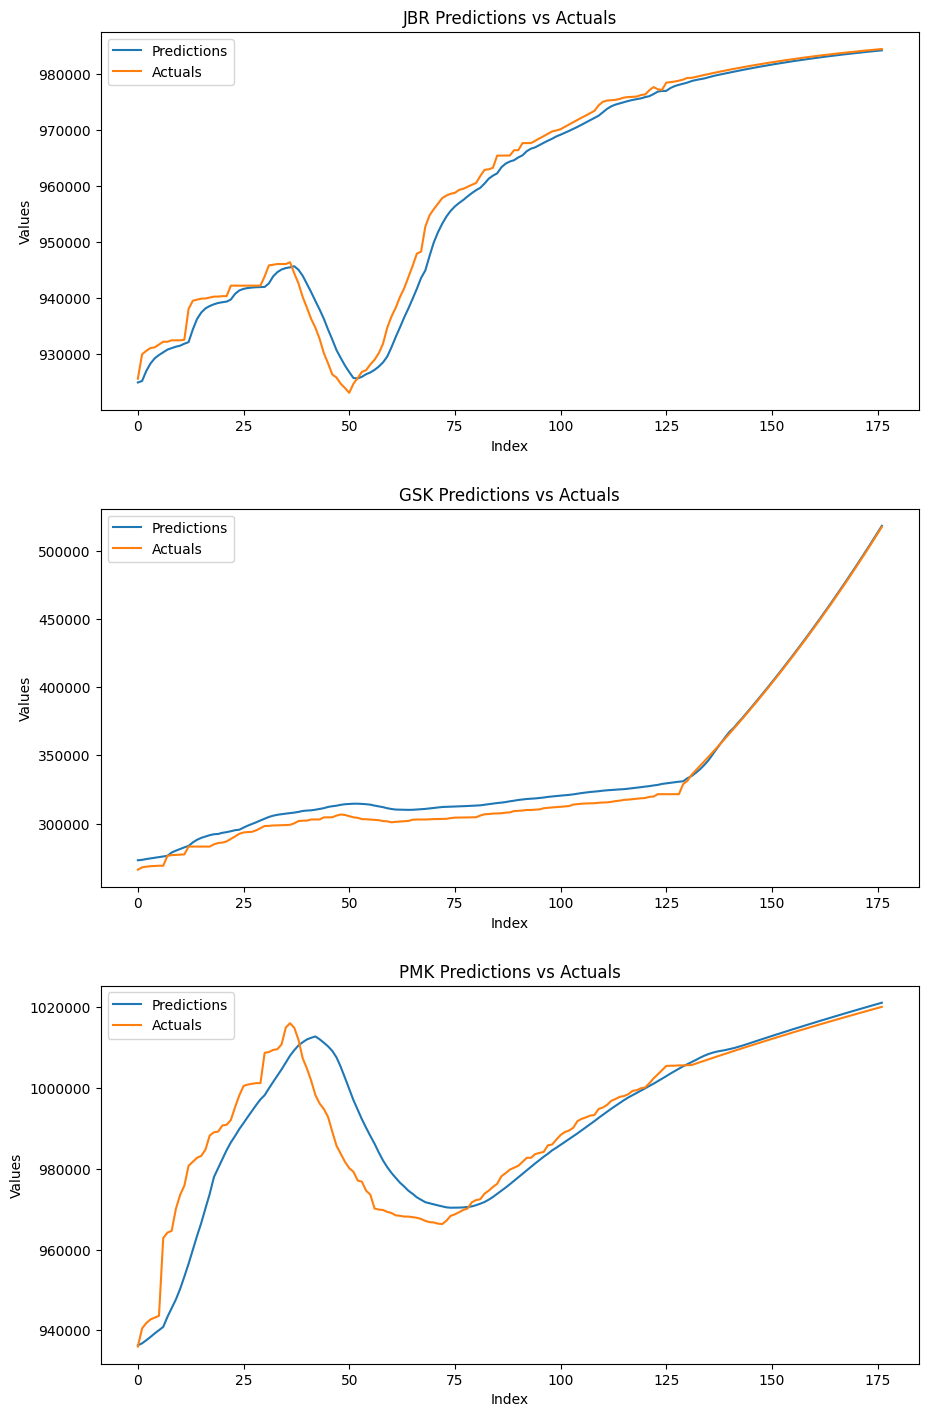

In [13]:
LSTM_train_results, LSTM_test_results = train_LSTM(0.8)
compare_pred_actual(LSTM_train_results)

#### ARIMA

Melakukan differencing data
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3093.008, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3096.796, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3095.699, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3109.978, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3115.492, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.232 seconds
Melakukan differencing data
Melakukan differencing data
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3166.984, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3175.282, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3168.428, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3168.899, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.212 seconds
Melakukan differencin

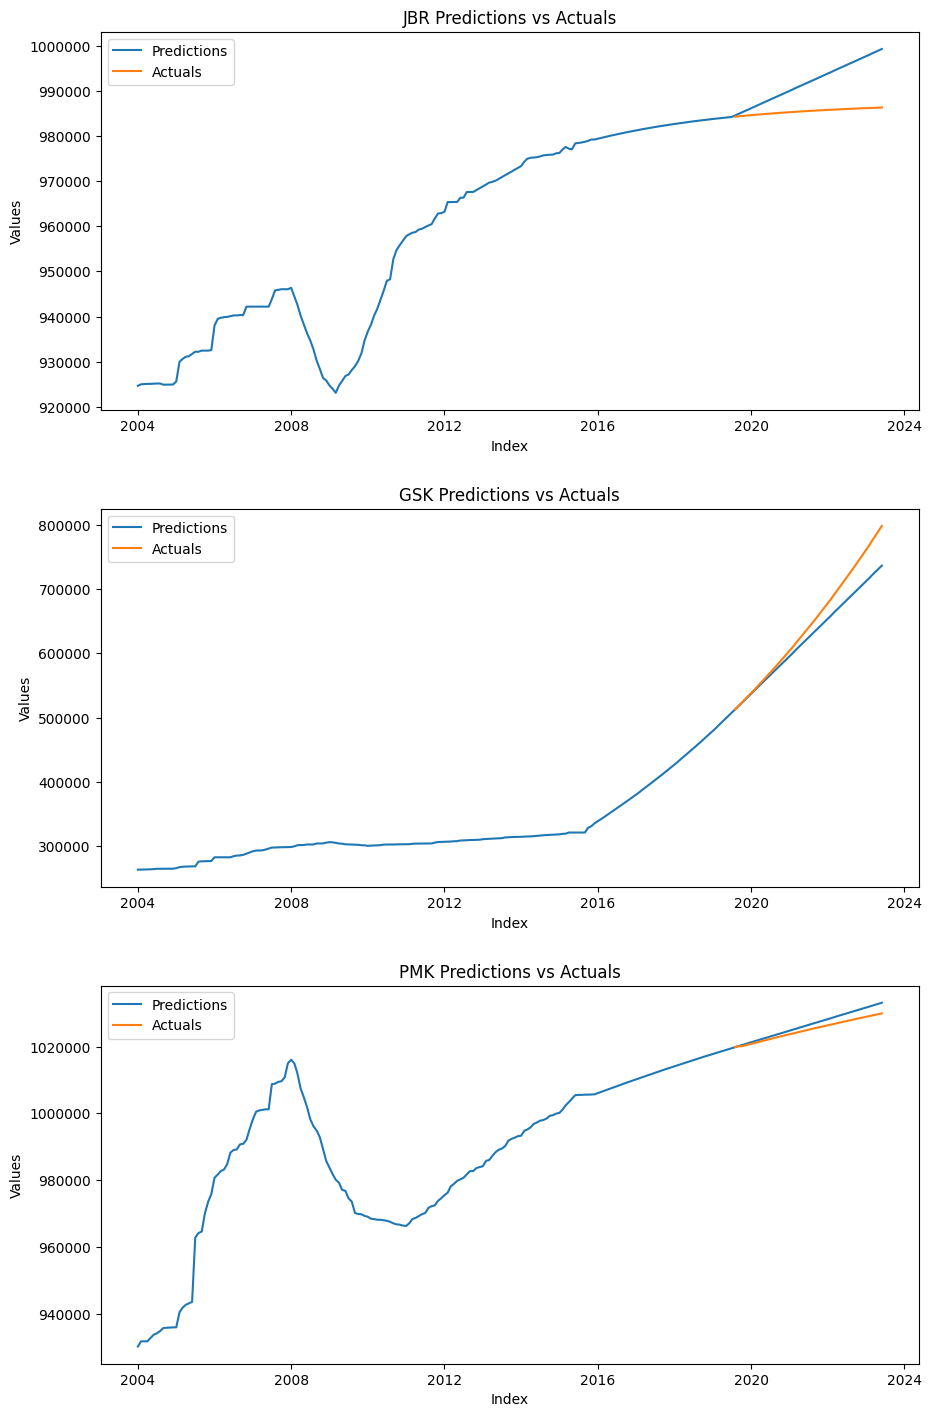

In [14]:
ARIMA_results = train_ARIMA(0.8)
compare_pred_actual(ARIMA_results)

#### ARIMA-LSTM

Dataset JBR
MAE = 6563.2676594984205
MAPE = 0.0066010585920355976
MSE = 55553219.43314832 

Dataset GSK
MAE = 20618.056694445826
MAPE = 0.030297928018124747
MSE = 738497049.6179758 

Dataset PMK
MAE = 1542.9357424931368
MAPE = 0.001501301695449679
MSE = 2610174.110405697 



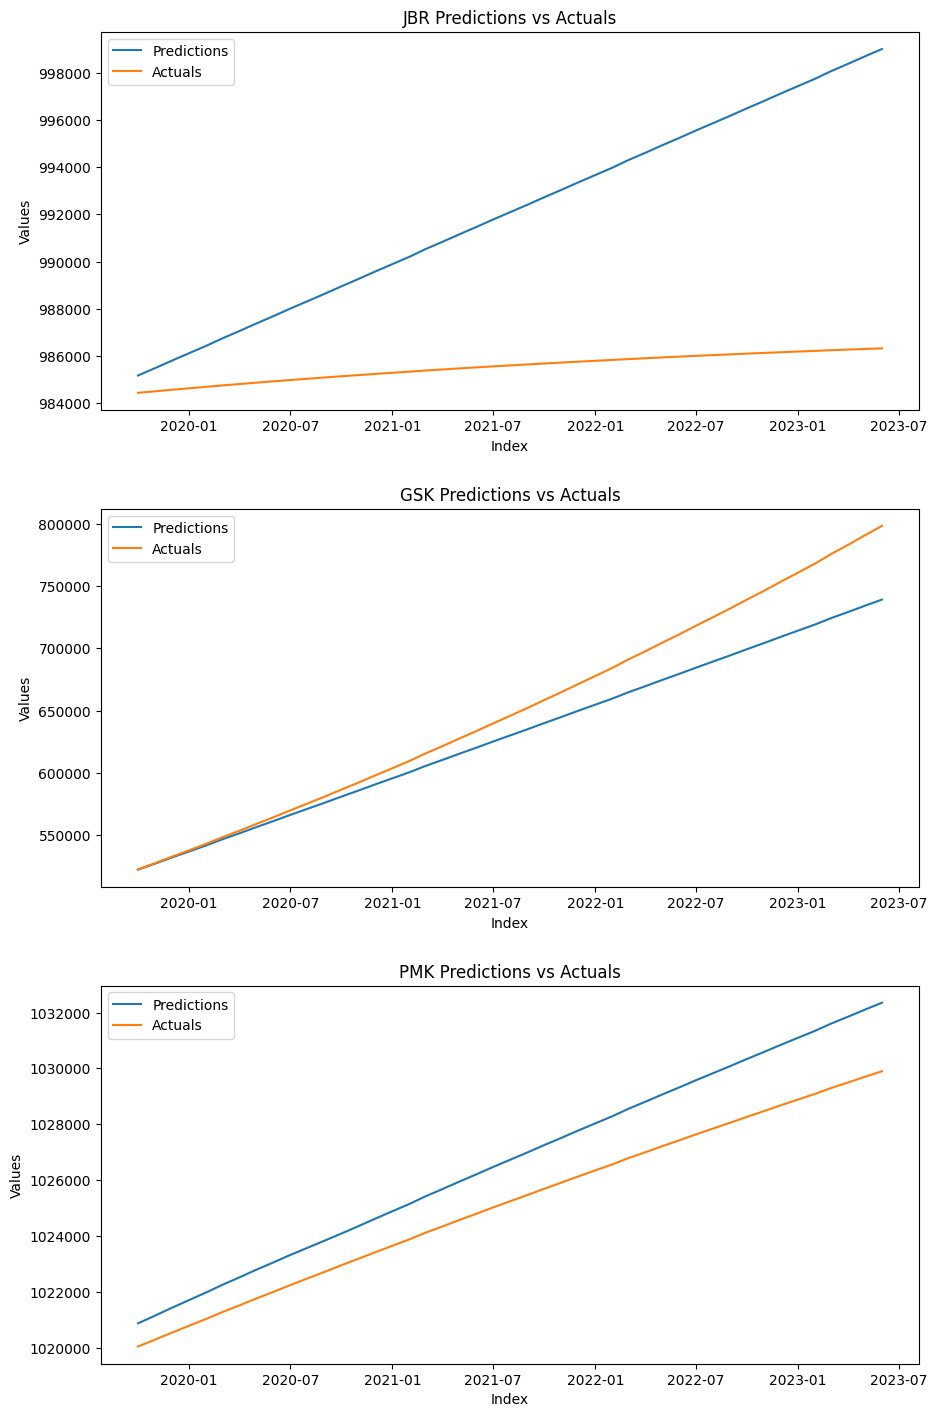

In [15]:
result = {}
LSTM_weight = {}
ARIMA_weight = {}
for reg in REGIONS:
    result[reg],LSTM_w,ARIMA_w = train_ARIMA_LSTM(create_ARIMA_LSTM(
        ARIMA_results[reg]['Predictions'],
        LSTM_test_results[reg]['Predictions'],
        reg
    ))
    LSTM_weight[reg] = LSTM_w
    ARIMA_weight[reg] = ARIMA_w
compare_pred_actual(result)
    

### 2. 70% Train 30% Test

#### LSTM

Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 818039685120.0000
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 294917505024.0000
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91059740672.0000
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67682398208.0000
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9124219904.0000 
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43315752.0000
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45122800.0000
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39476500.0000
Epoch 9/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54804632.0000
Epoch 10/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47915724.0000
Epoch 11/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61313816.0000
Epoch 12/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61265812.0000
Epoch 13/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49081224.0000
Epoch 14/100
78/78 ━━━━━━━━━━━

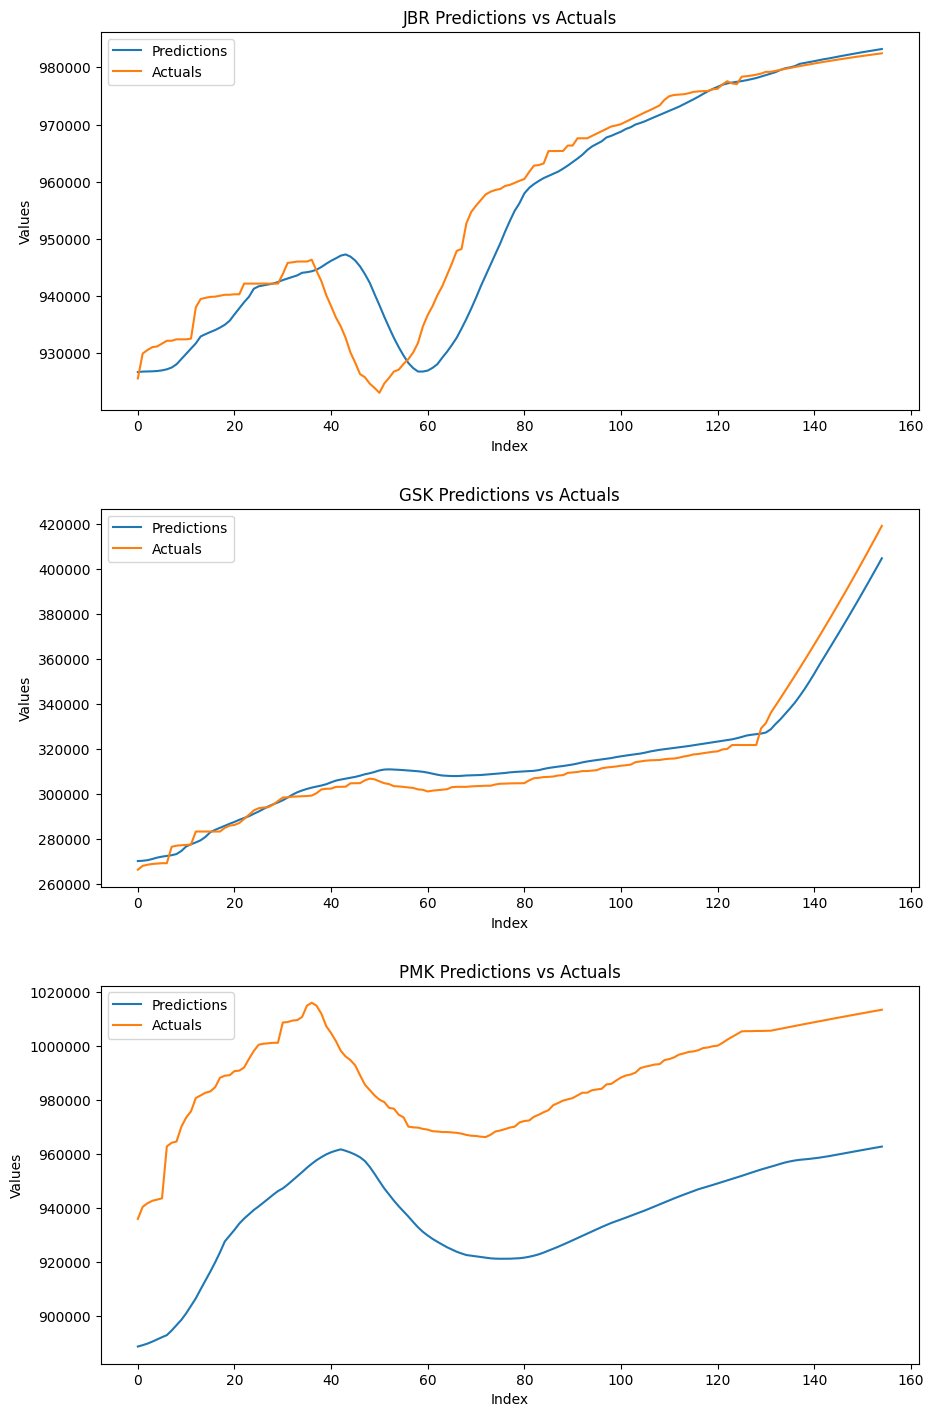

In [16]:
LSTM_train_results, LSTM_test_results = train_LSTM(0.7)
compare_pred_actual(LSTM_train_results)

#### ARIMA

Melakukan differencing data
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2715.495, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2719.163, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2718.076, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2731.157, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2719.482, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.234 seconds
Melakukan differencing data
Melakukan differencing data
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2778.742, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2786.302, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2780.316, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2780.684, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.131 seconds
Performing stepwise s

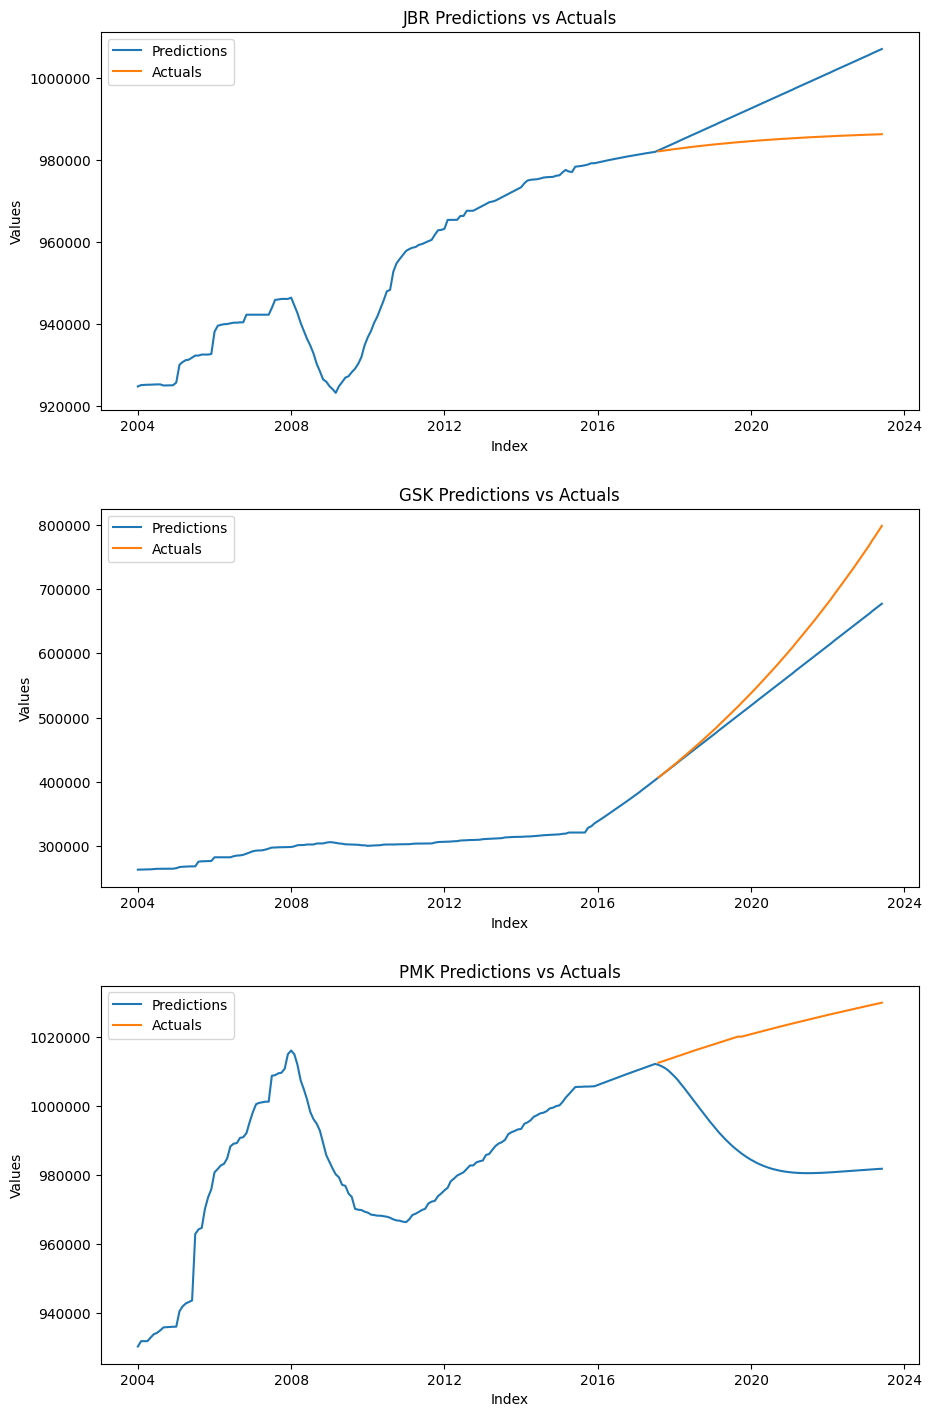

In [17]:
ARIMA_results = train_ARIMA(0.7)
compare_pred_actual(ARIMA_results)

#### ARIMA-LSTM

Dataset JBR
MAE = 9585.225222376954
MAPE = 0.009606271249767193
MSE = 118754008.55471303 

Dataset GSK
MAE = 34431.323325145364
MAPE = 0.056586556456366455
MSE = 1820687216.8623846 

Dataset PMK
MAE = 44370.43306783669
MAPE = 0.04536883029660362
MSE = 1996775155.877098 



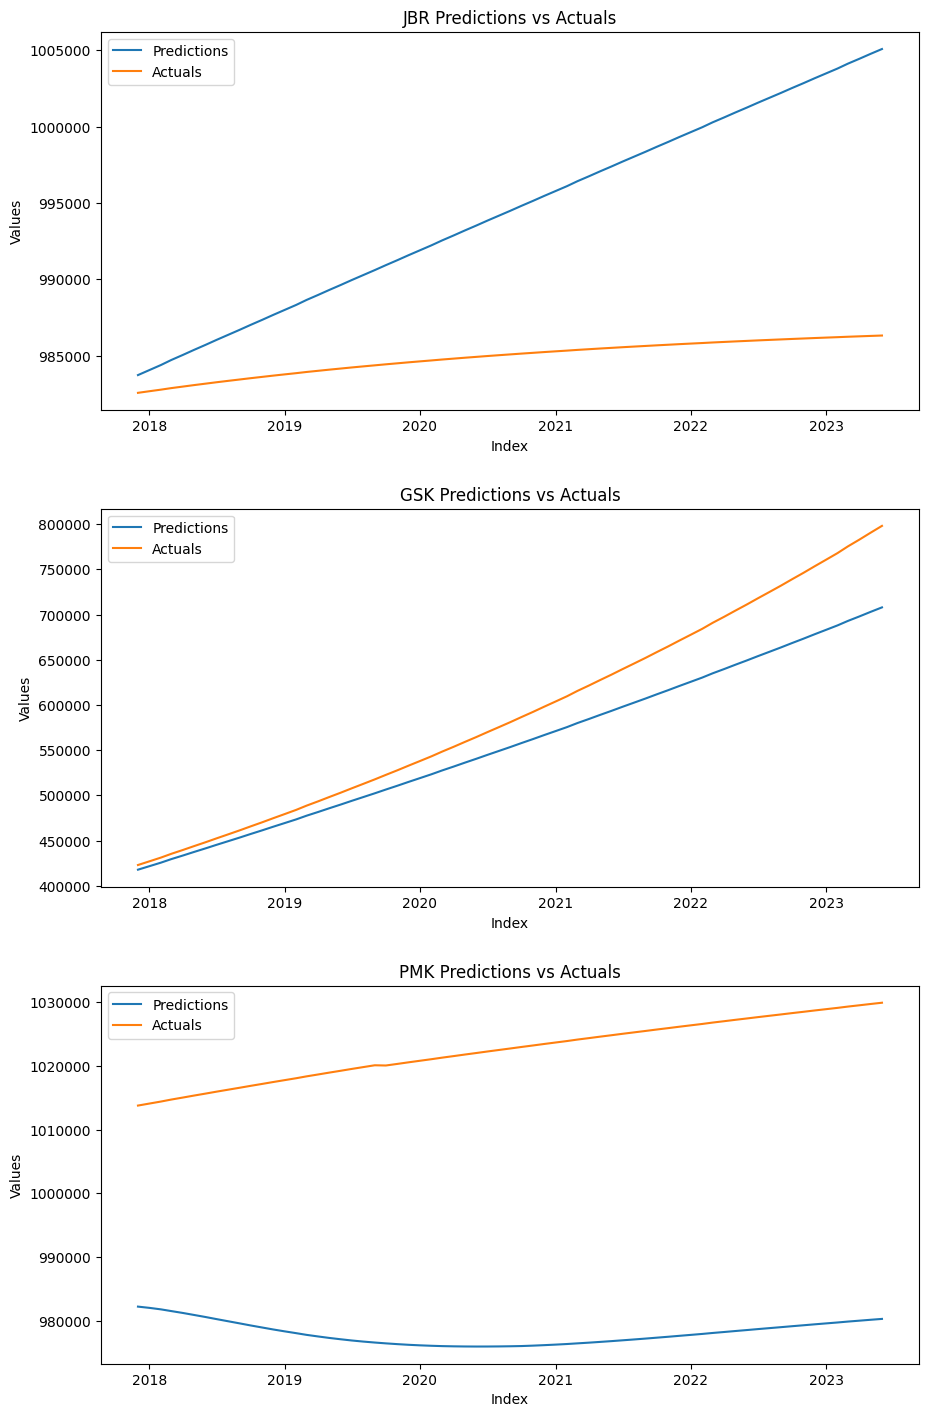

In [18]:
result = {}
for reg in REGIONS:
    result[reg],_,_ = train_ARIMA_LSTM(create_ARIMA_LSTM(
        ARIMA_results[reg]['Predictions'],
        LSTM_test_results[reg]['Predictions'],
        reg
    ))
compare_pred_actual(result)
    

### 3. 60% Train 40% Test

#### LSTM

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1355290771456.0000
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43597733888.0000
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3001512704.0000
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 272689037312.0000
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2878541056.0000
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3565979648.0000
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3985998080.0000
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52436972.0000
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44945868.0000
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55635424.0000
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34606228.0000
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50796972.0000
Epoch 13/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49802756.0000
Epoch 14/100
67/67 ━━━━━━━━

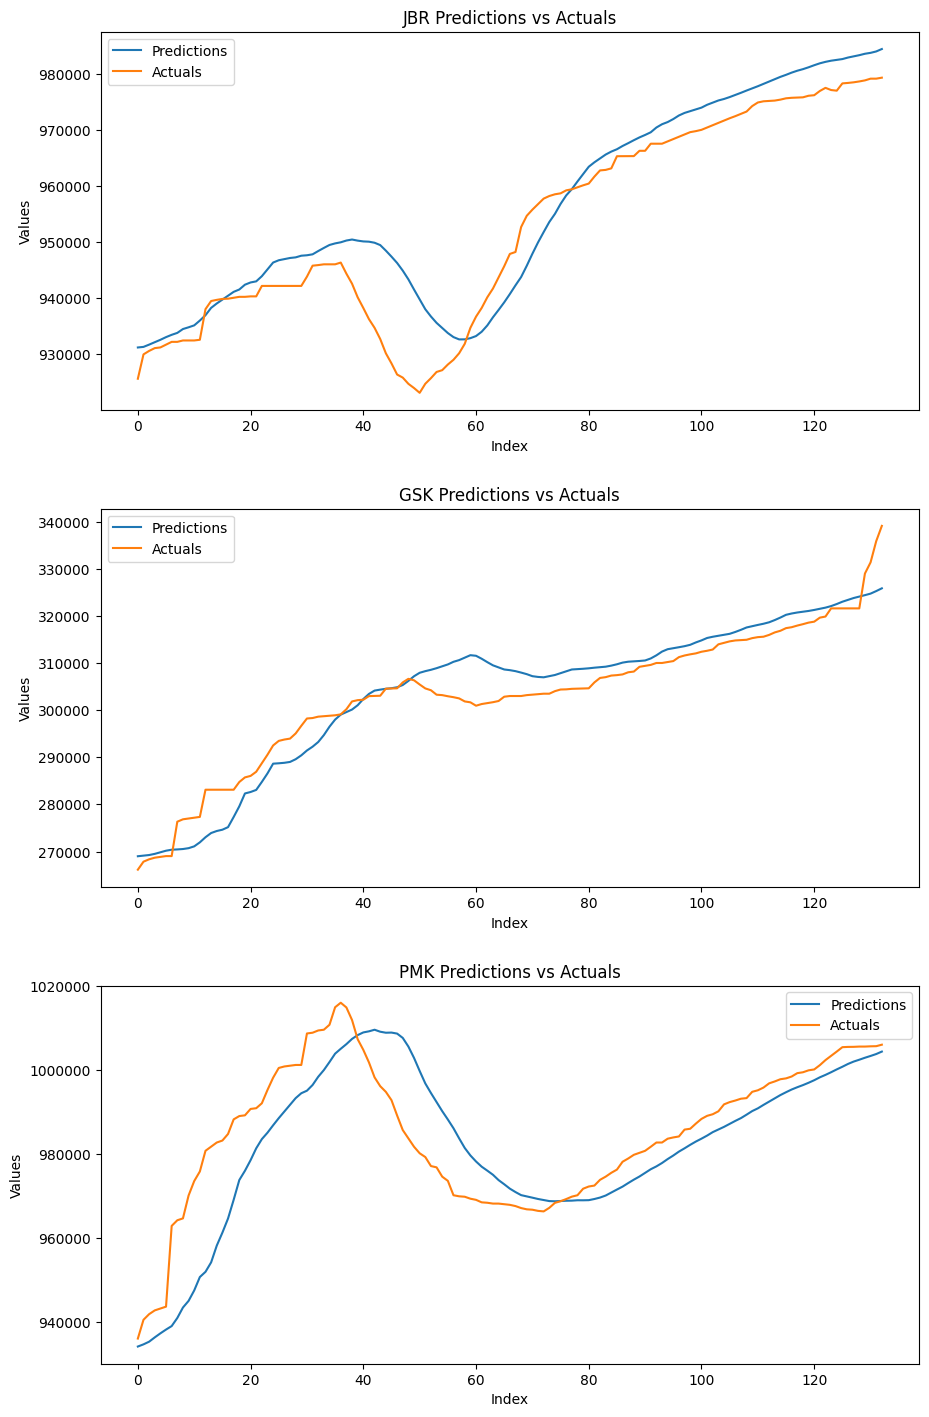

In [19]:
LSTM_train_results, LSTM_test_results = train_LSTM(0.6)
compare_pred_actual(LSTM_train_results)

#### ARIMA

Melakukan differencing data
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2350.881, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2354.366, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2353.355, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2364.567, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2367.347, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.238 seconds
Melakukan differencing data
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2293.625, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2295.984, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2295.715, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2317.757, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2297.623, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.143 seconds
Performing stepwise search to minimize aic
 

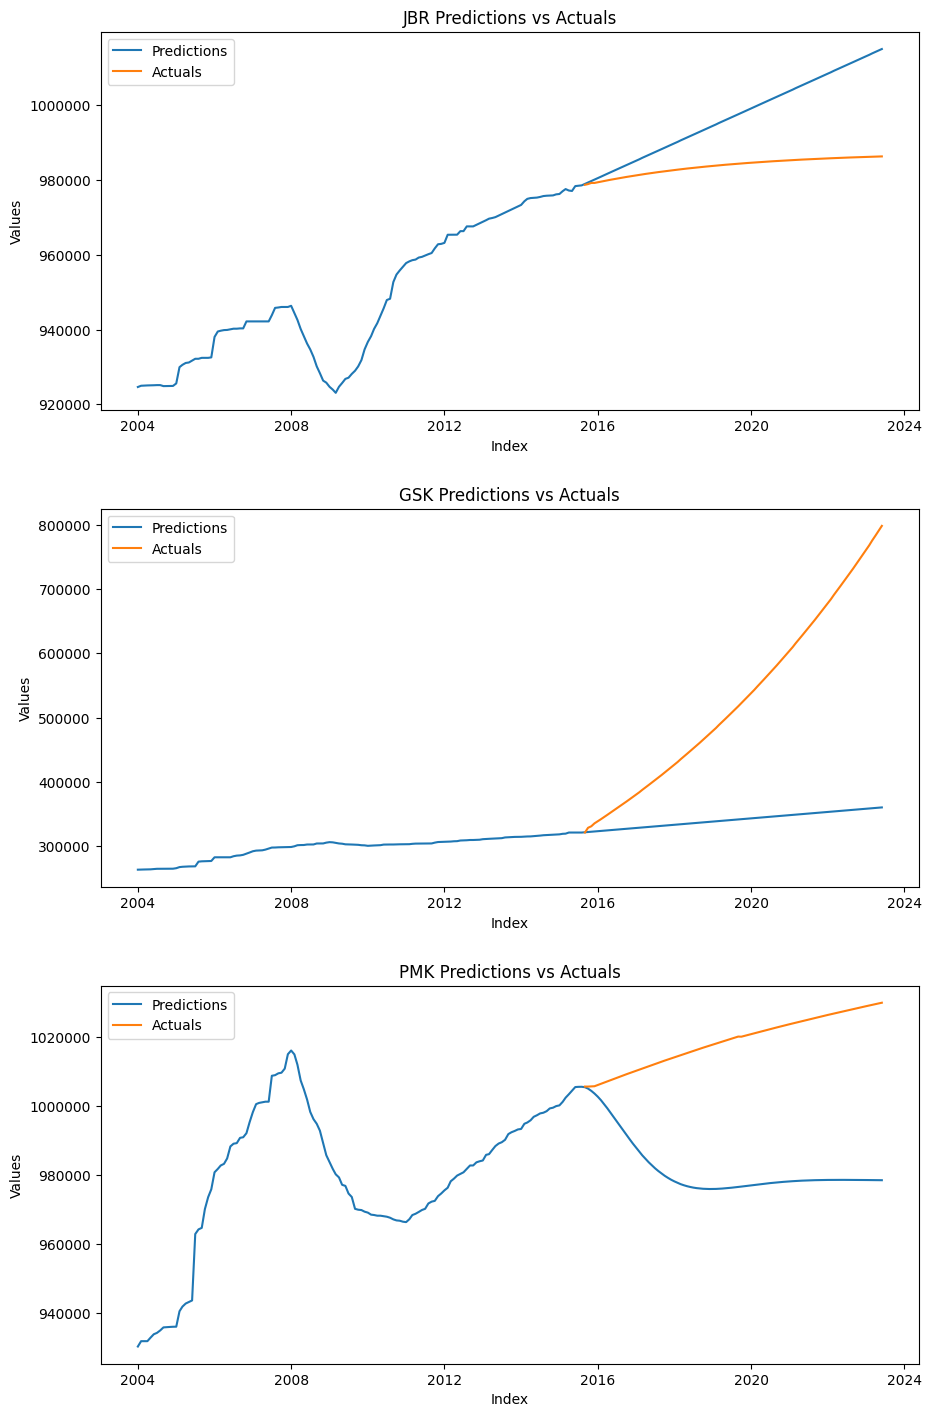

In [20]:
ARIMA_results = train_ARIMA(0.6)
compare_pred_actual(ARIMA_results)

#### ARIMA-LSTM

Dataset JBR
MAE = 11620.360917564993
MAPE = 0.011628325833518985
MSE = 168437321.07914314 

Dataset GSK
MAE = 169273.75401945348
MAPE = 0.43862919618615925
MSE = 39097690833.82429 

Dataset PMK
MAE = 38060.48724529653
MAPE = 0.03884963201639154
MSE = 1583439756.1328096 



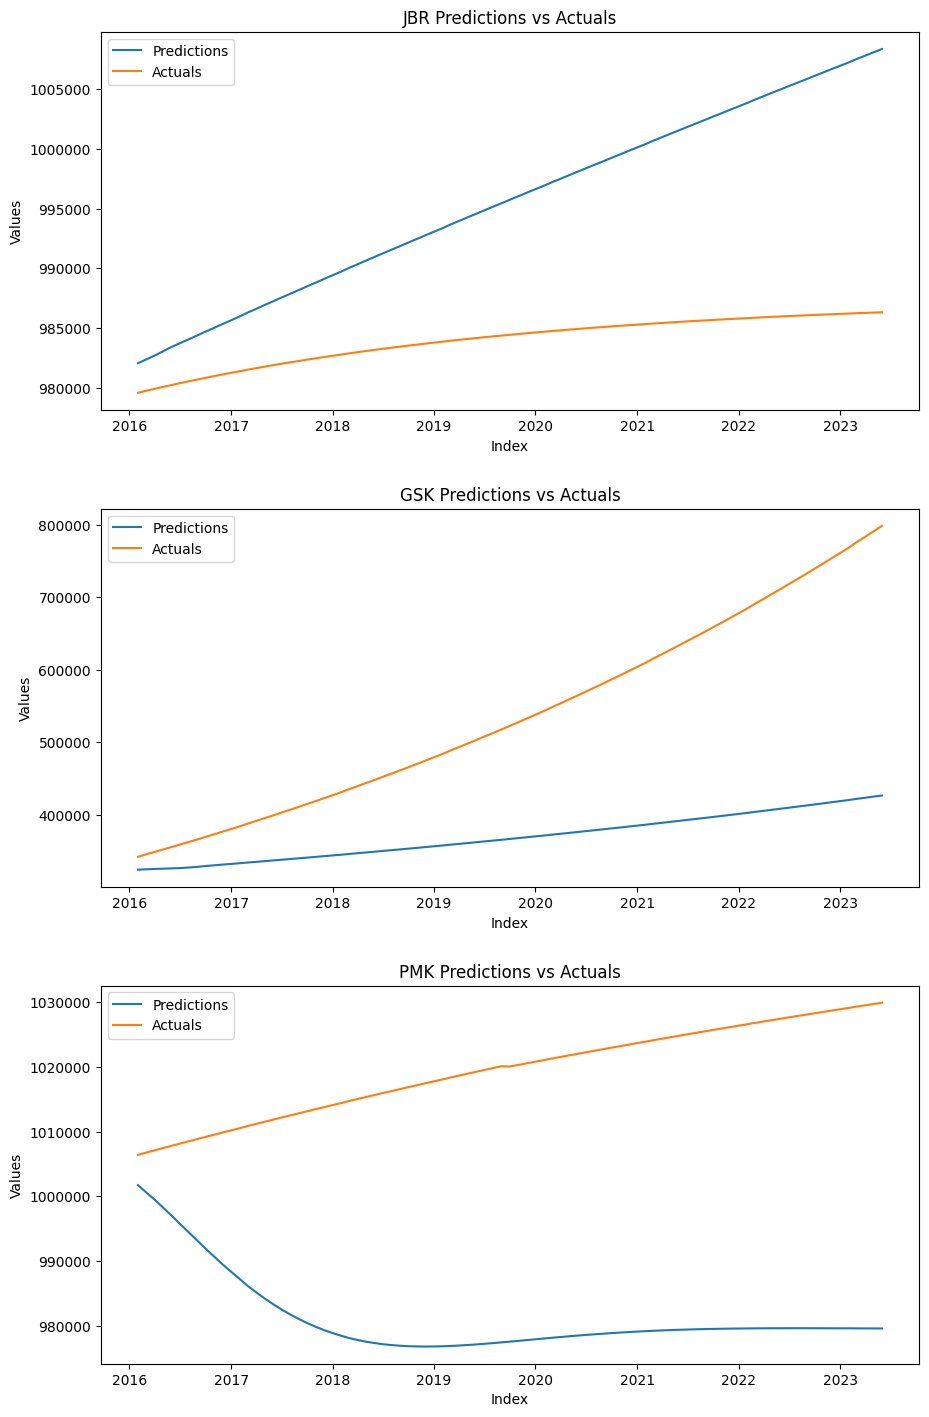

In [21]:
result = {}
for reg in REGIONS:
    result[reg],_,_ = train_ARIMA_LSTM(create_ARIMA_LSTM(
        ARIMA_results[reg]['Predictions'],
        LSTM_test_results[reg]['Predictions'],
        reg
    ))
compare_pred_actual(result)
    

## Forecast

### Combine Historical & Forecast

In [75]:
def combine_data(region, forecast, data):
    historical = data[['Periode', region]].copy()
    historical.columns = ['Periode', 'Historical']
    forecast.columns = ['Periode', 'Forecast']
    combined = pd.merge(historical, forecast, on='Periode', how='outer')
    return combined

### ARIMA

Melakukan differencing data
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3824.793, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3854.577, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3827.675, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3842.953, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3853.983, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.197 seconds
Melakukan differencing data
Melakukan differencing data
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3918.668, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3928.256, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3935.450, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3922.515, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3920.471, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.133 seconds
Melakukan differ

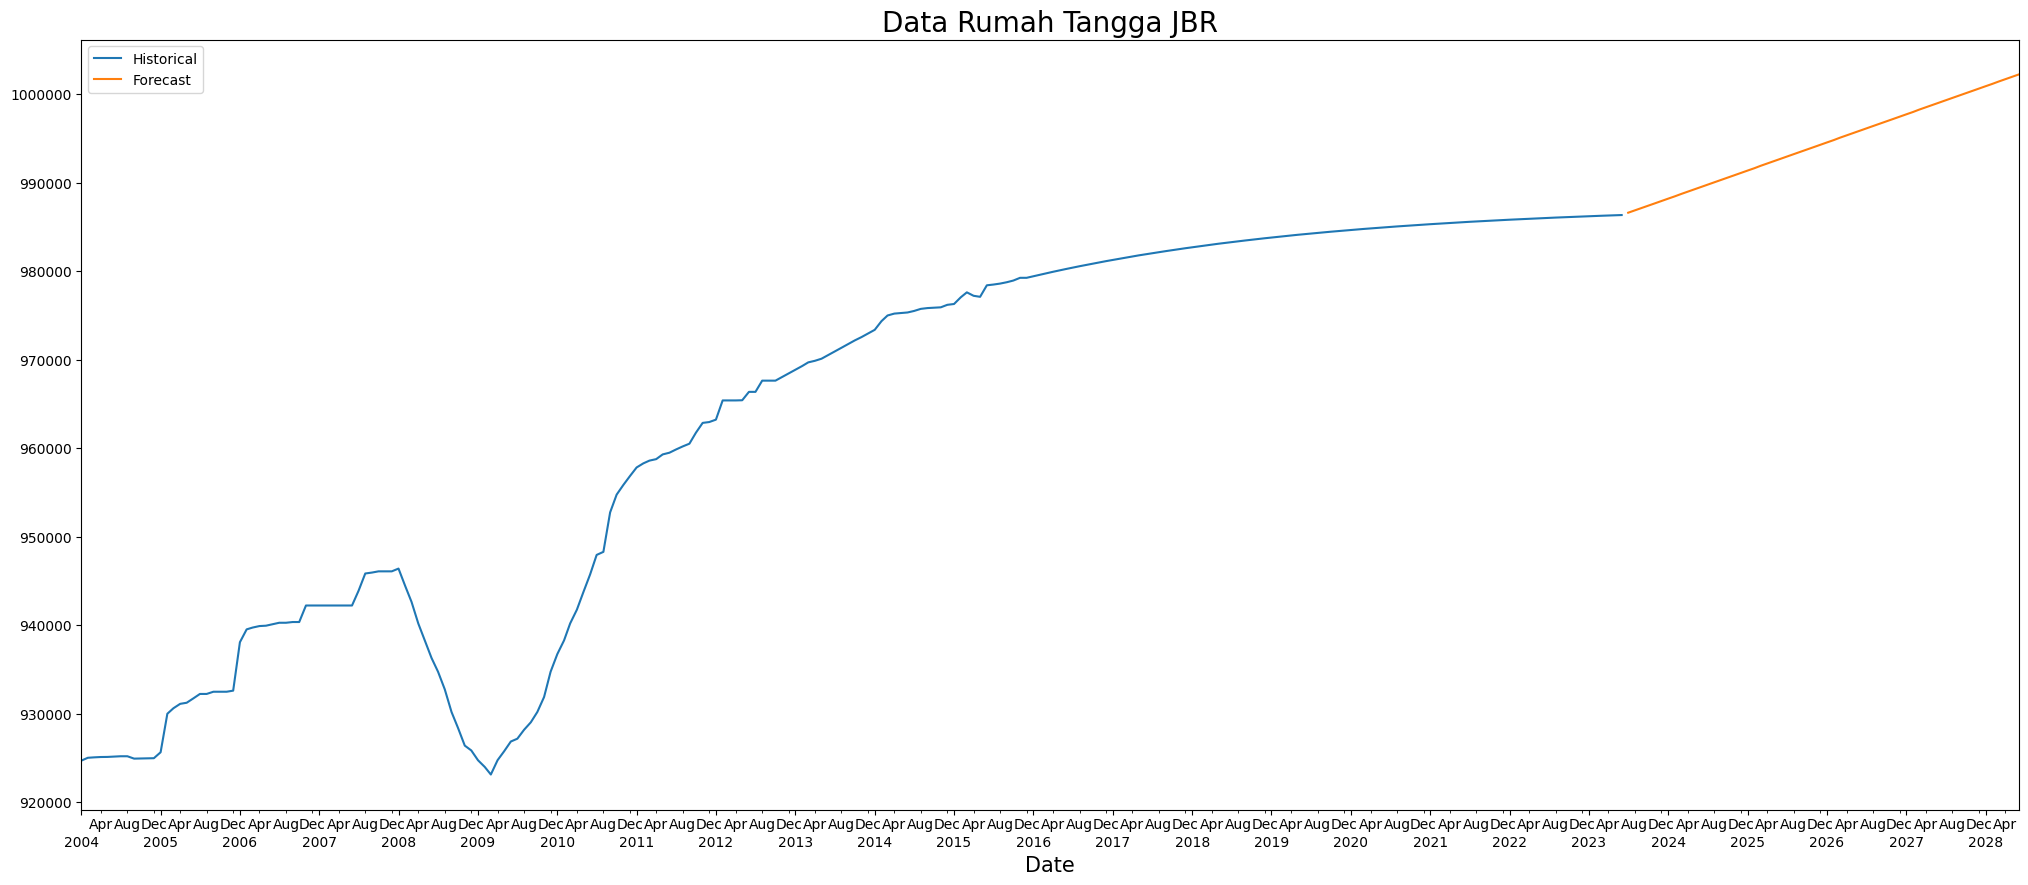

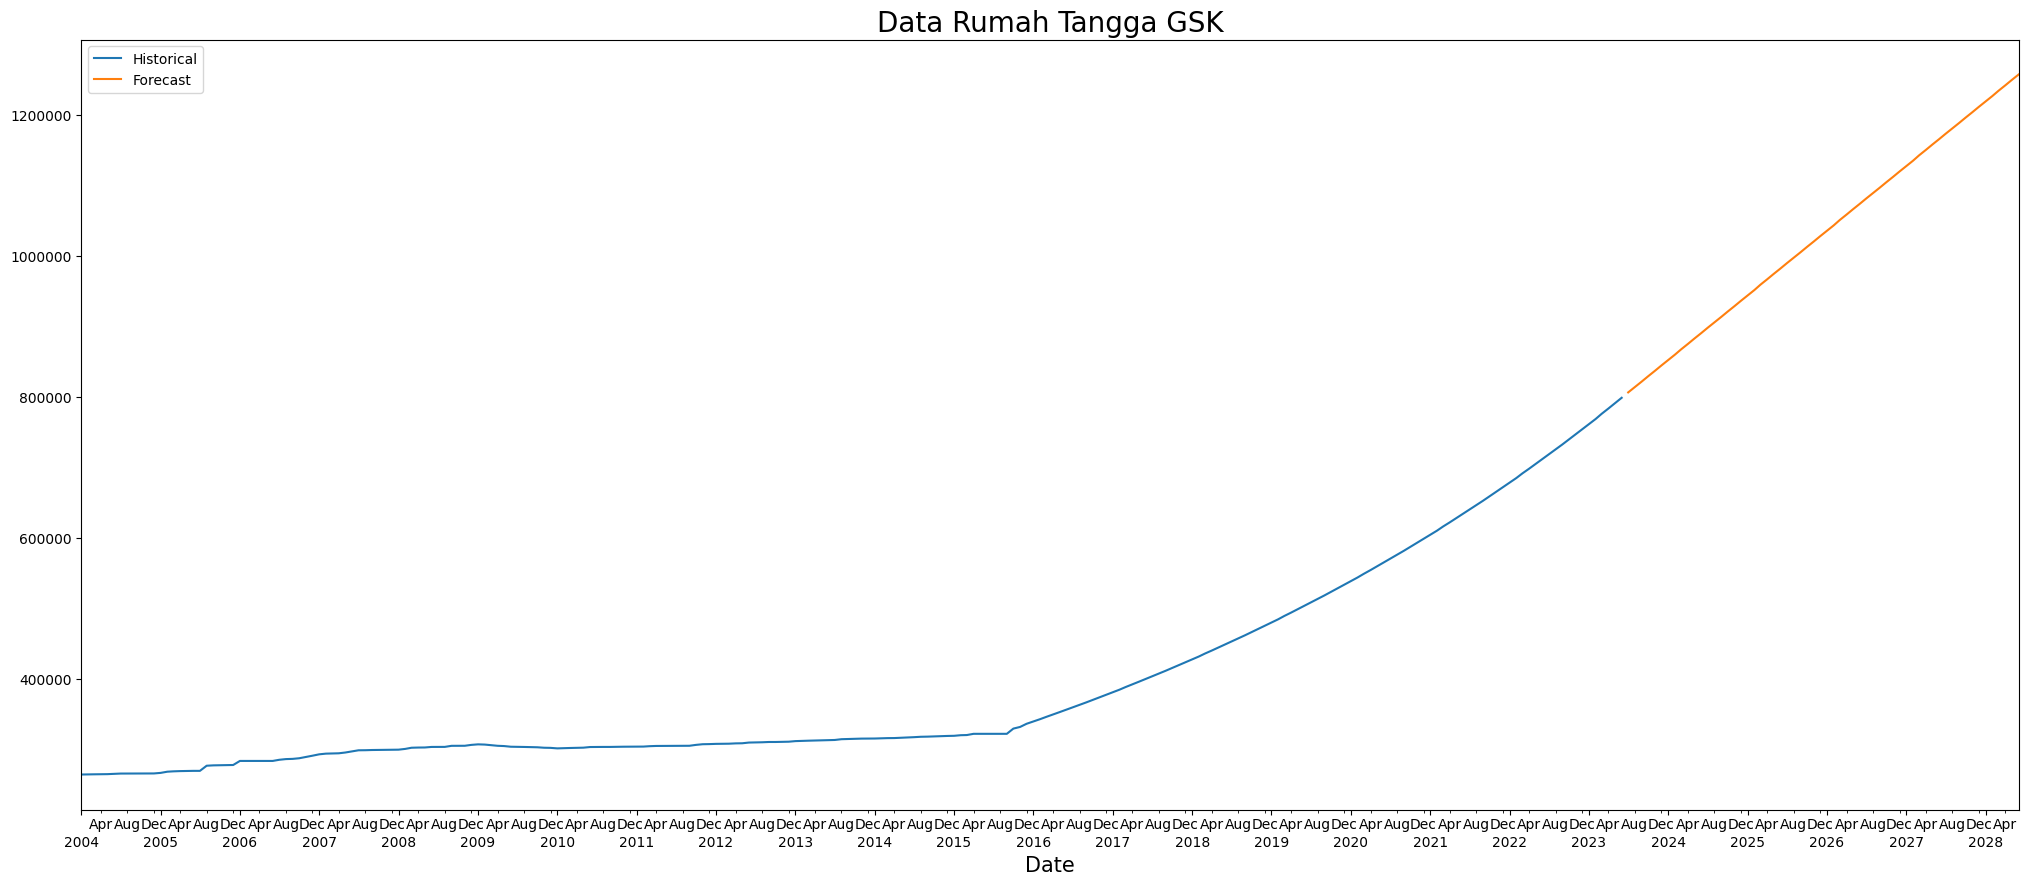

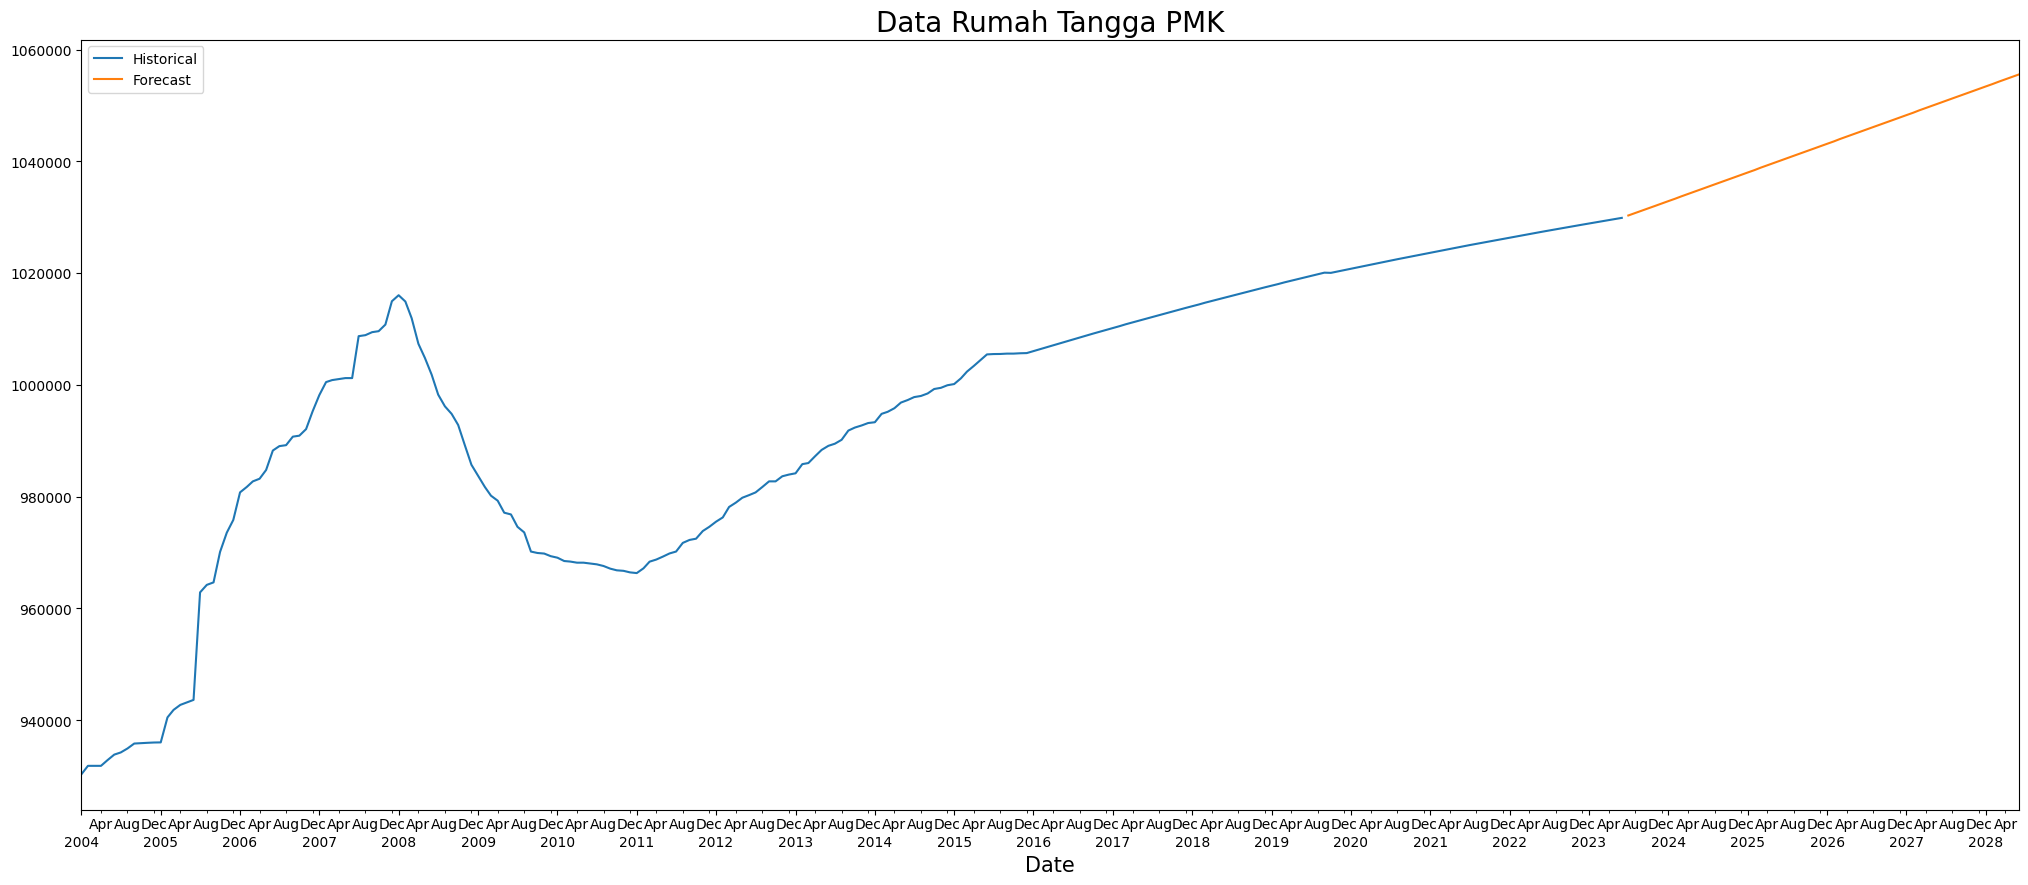

In [89]:
ARIMA_forecast = forecast_ARIMA(FORECAST_WINDOW)
for region in REGIONS:
    forecast = ARIMA_forecast[region]
    forecast = forecast.reset_index()
    forecast.columns = ['Periode', 'Forecast']
    forecast = forecast.reset_index().drop('index', axis=1)
    combined_data = combine_data(region, forecast, data)
    visualize(combined_data, var=['Historical', 'Forecast'], label=region)

### LSTM

In [145]:
LSTM_forecast = forecast_LSTM(FORECAST_WINDOW)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1305
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0059
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0072
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067
Epoch 13/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0053
Epoch 14/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042
Epoch 15/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1

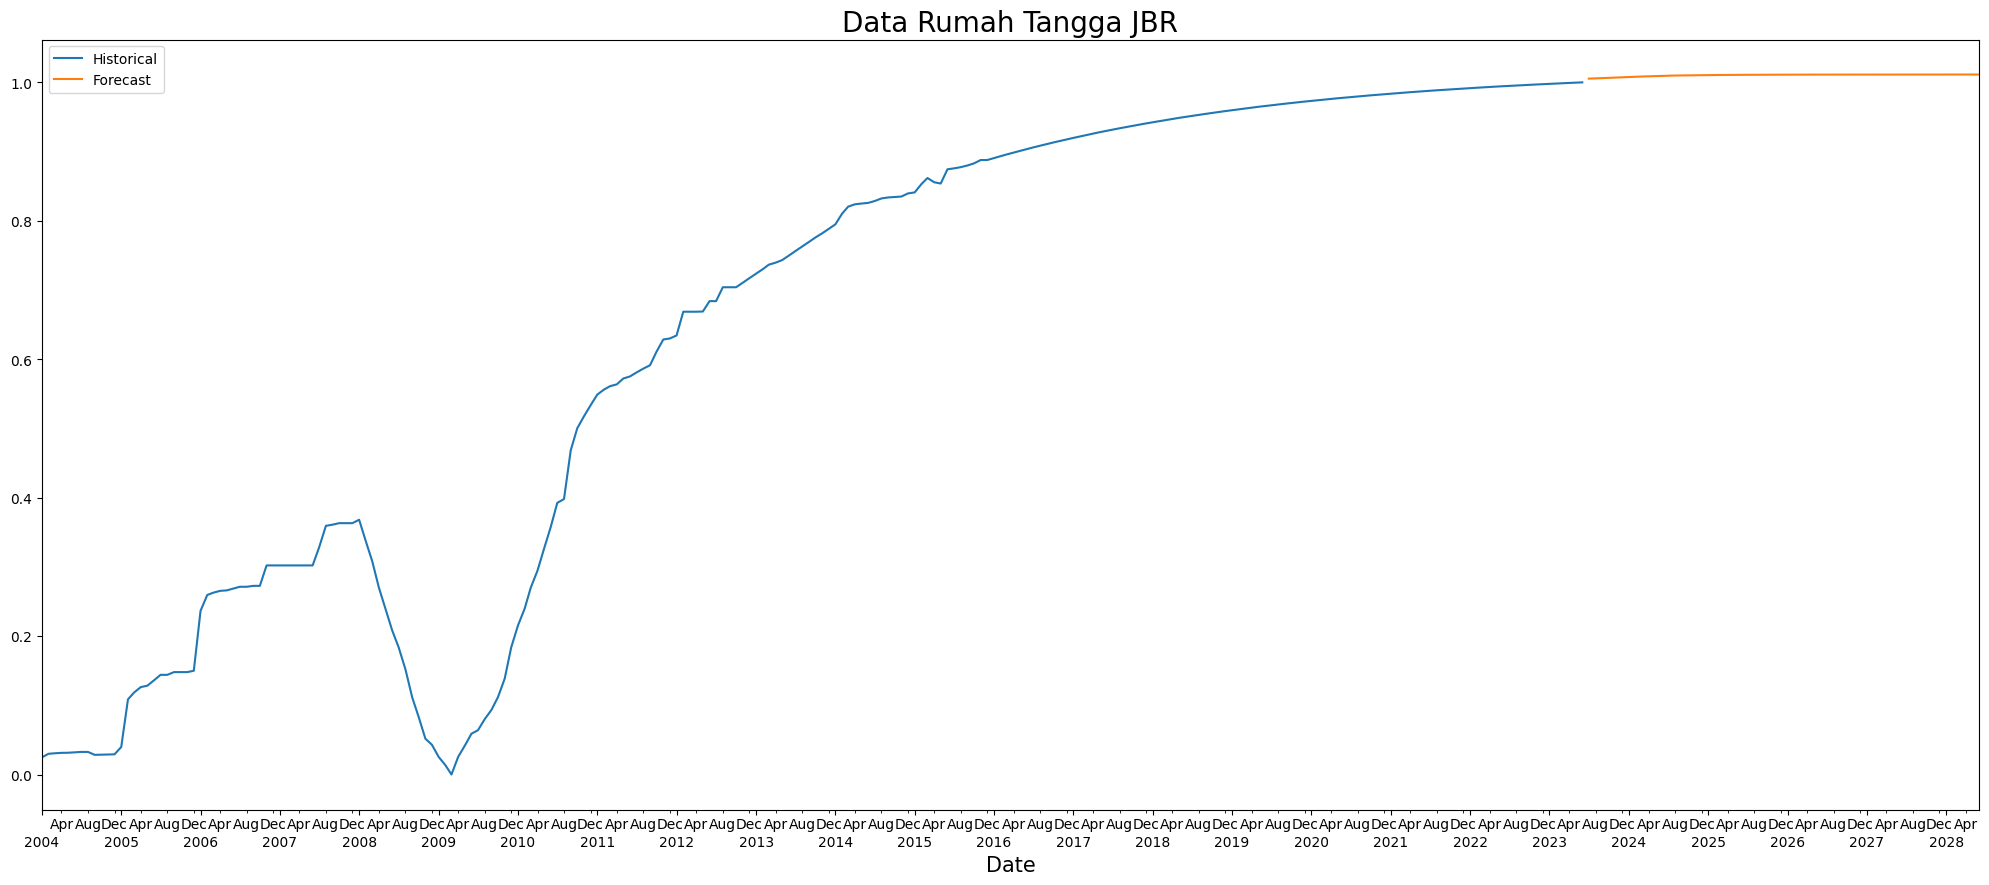

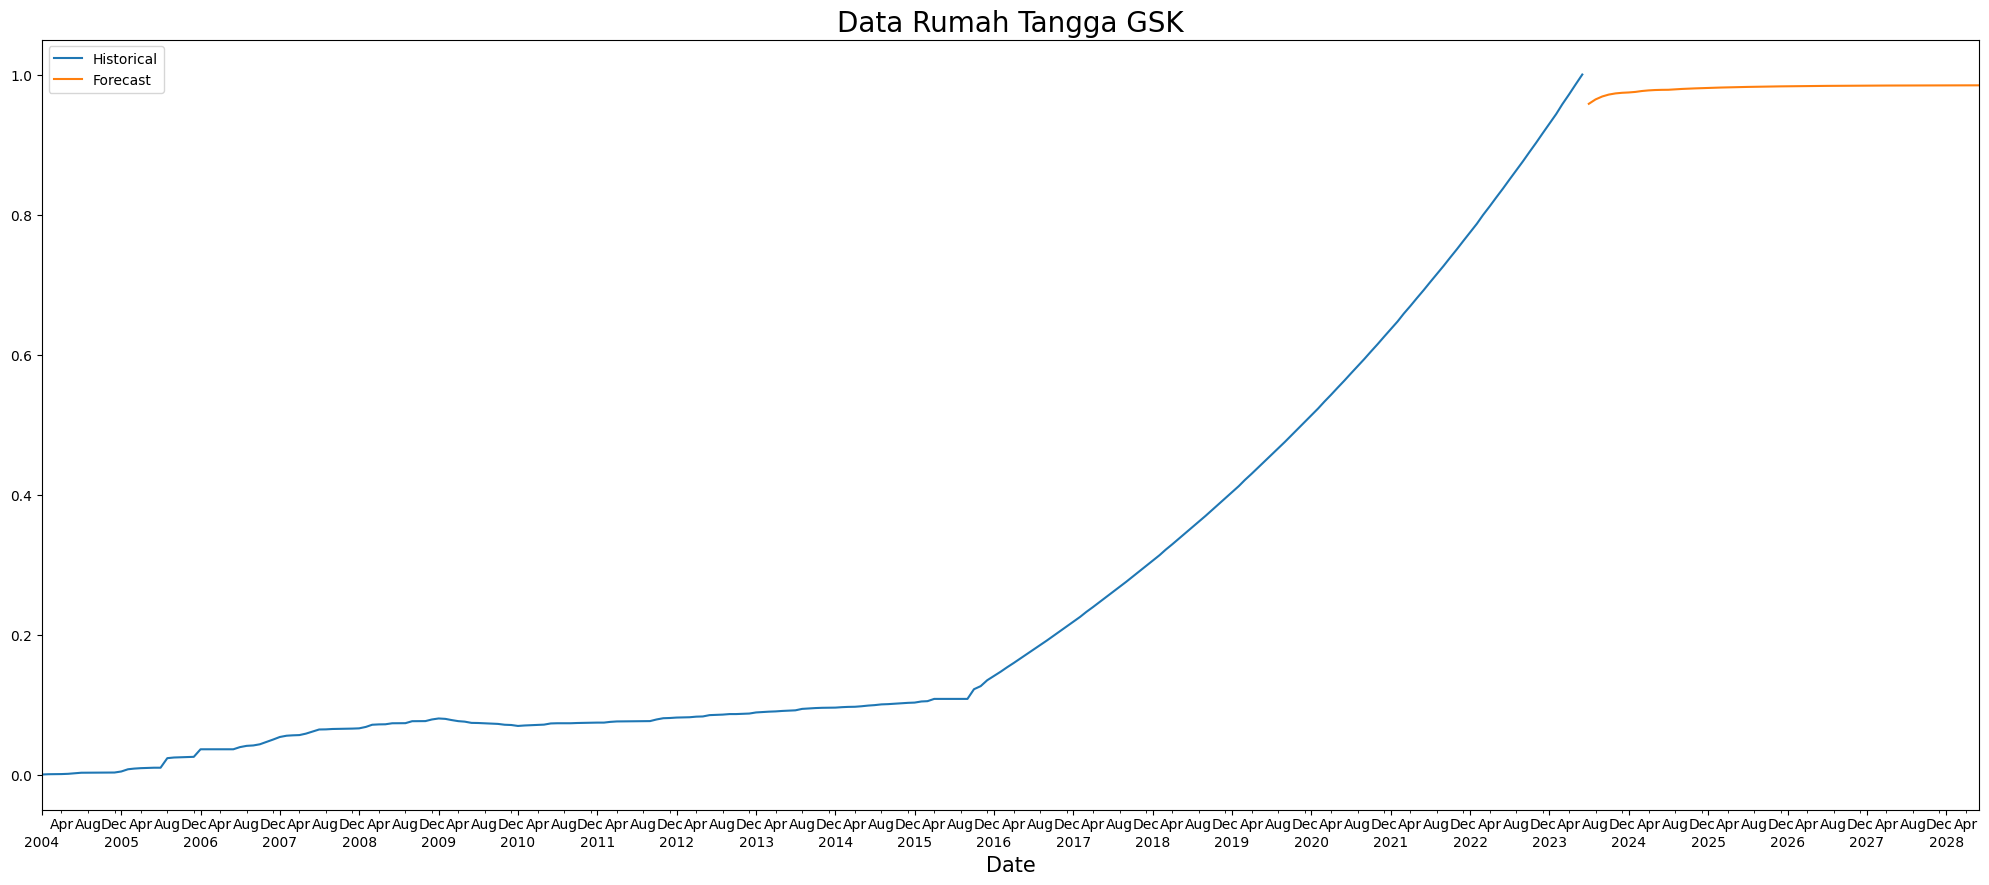

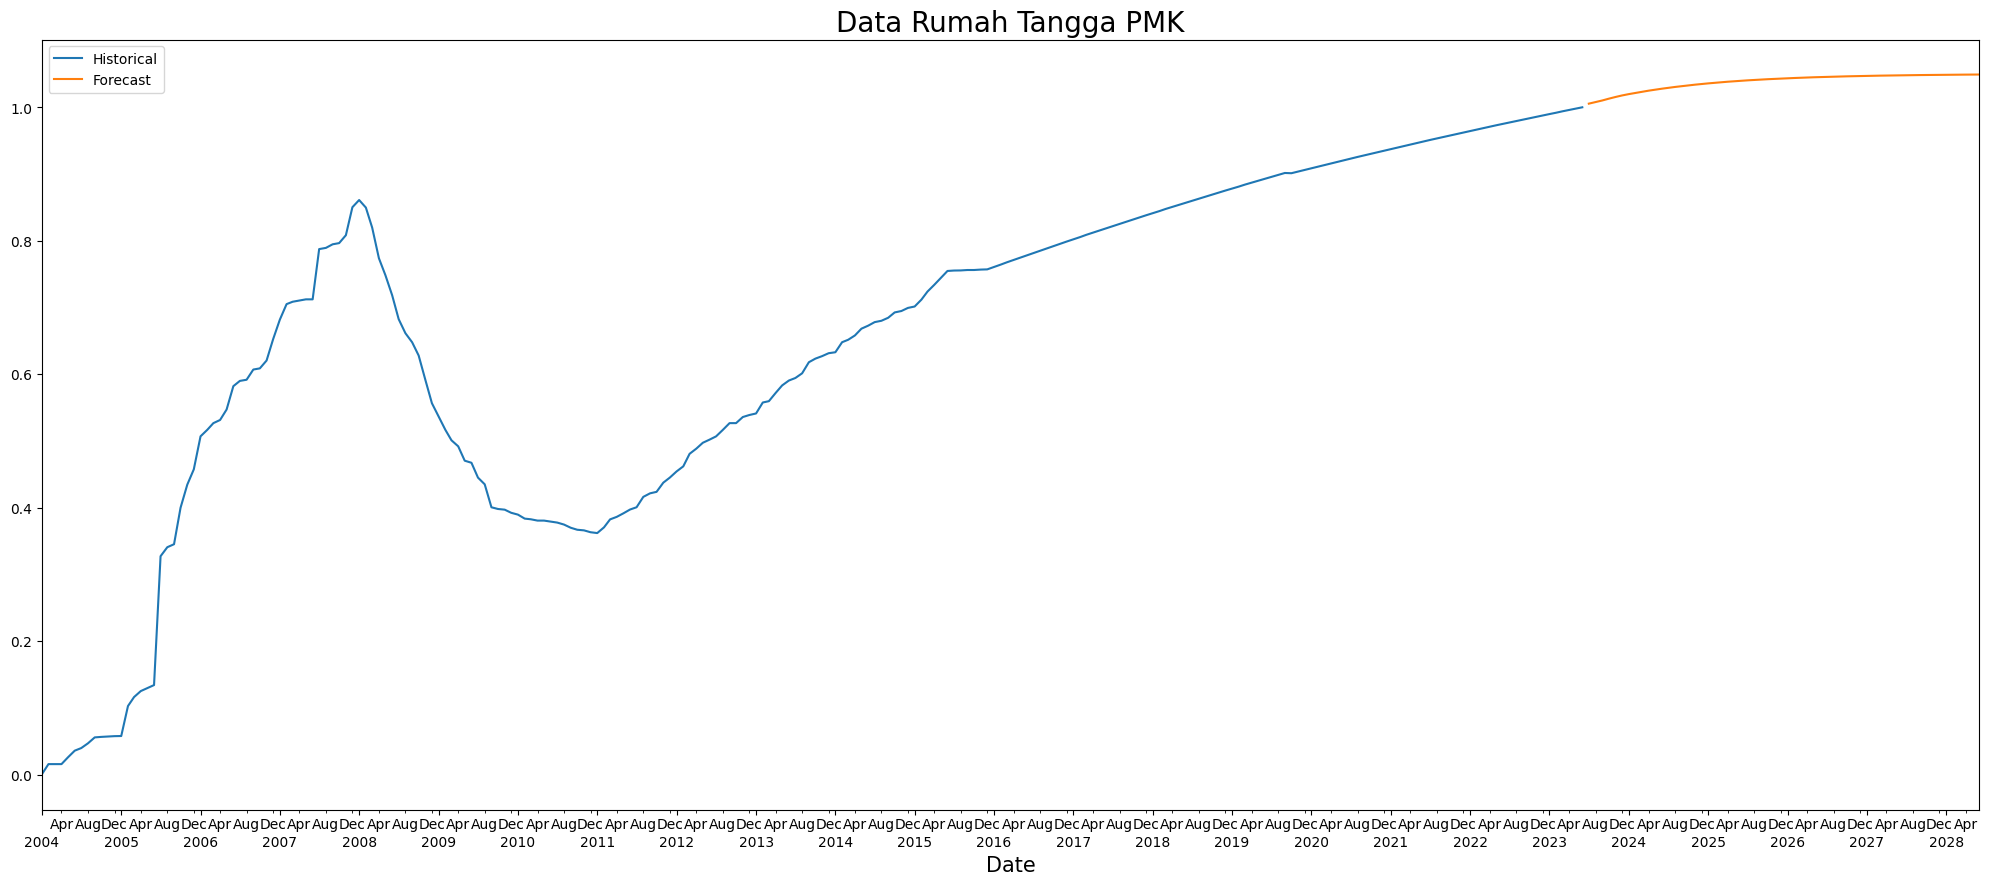

In [146]:
for region in REGIONS:
    forecast = LSTM_forecast[region]
    forecast = forecast.reset_index()
    combined_data = combine_data(region, forecast, data)
    visualize(combined_data, var=['Historical', 'Forecast'], label=region)

### ARIMA-LSTM

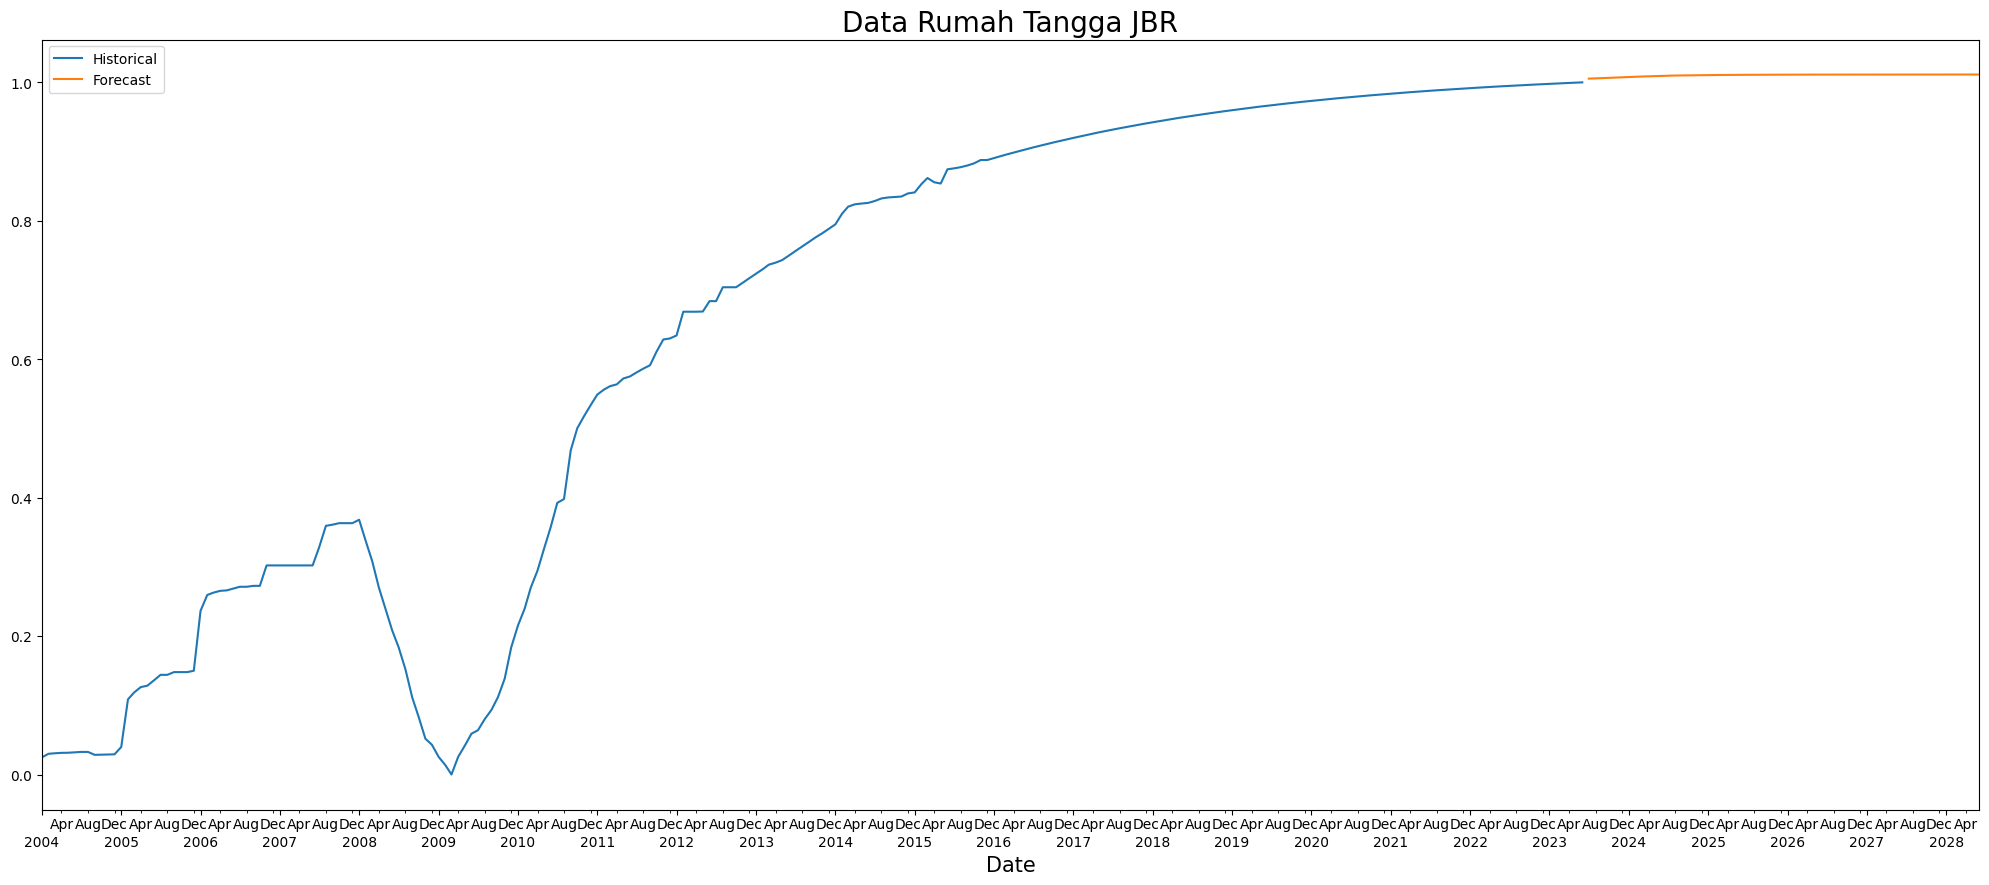

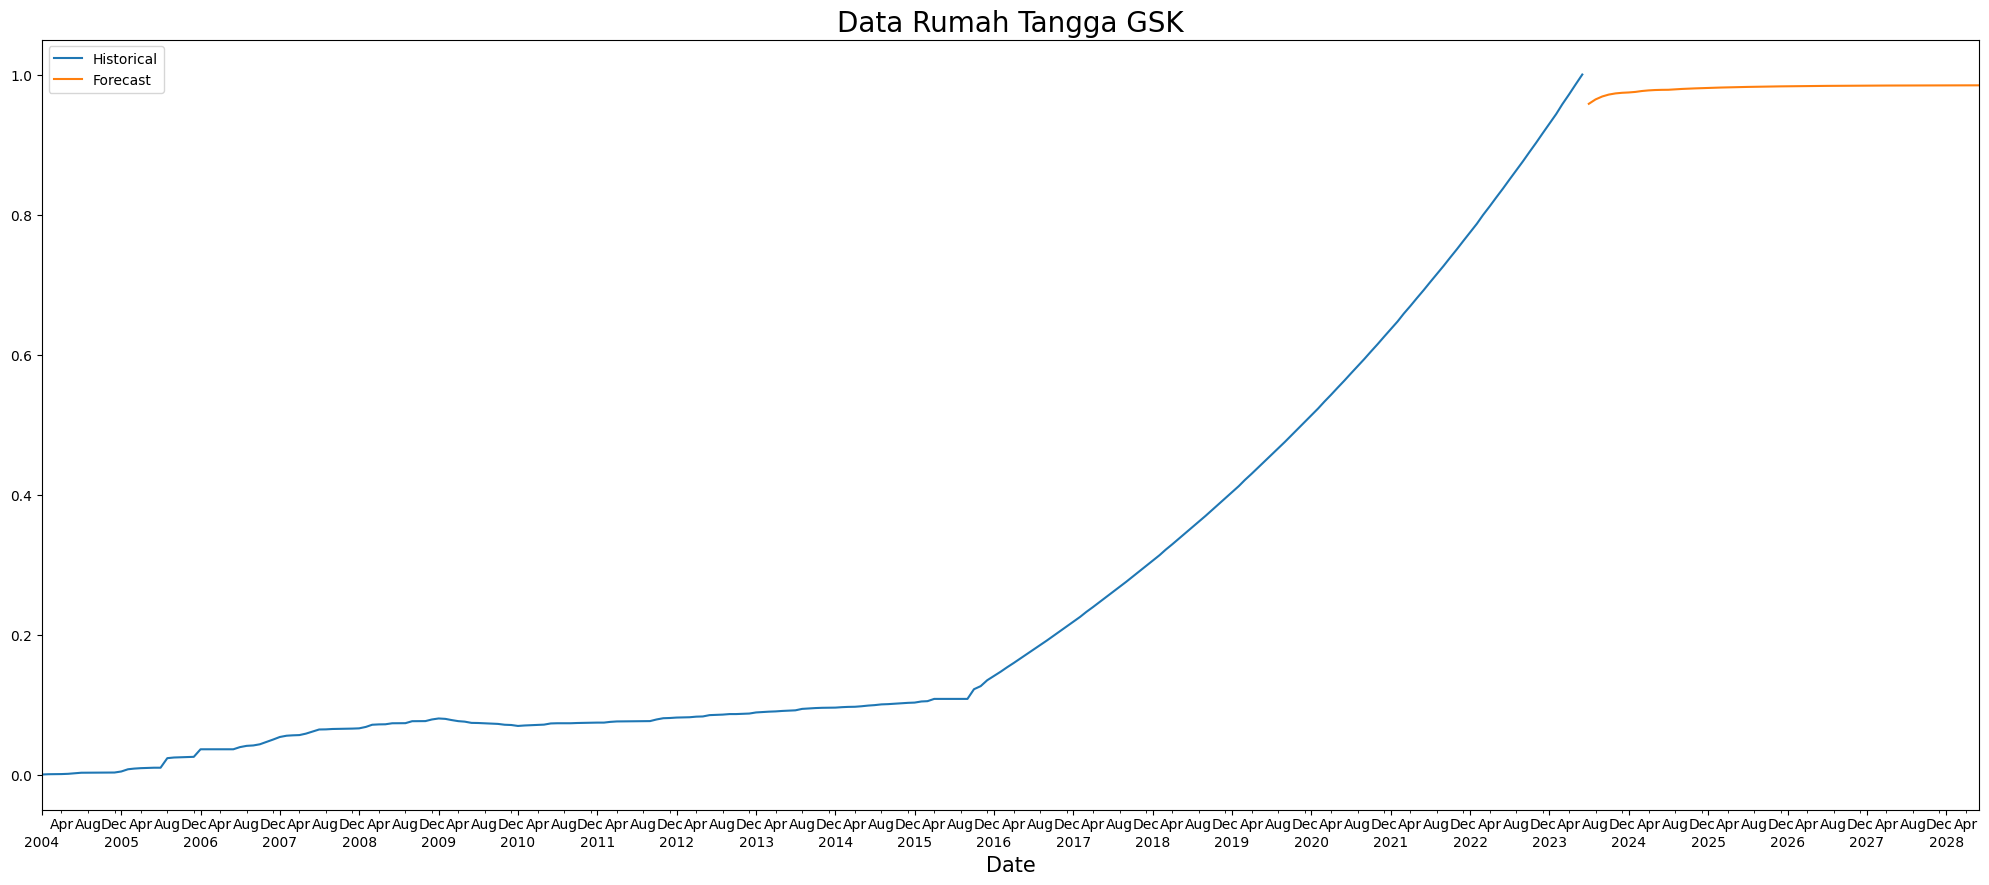

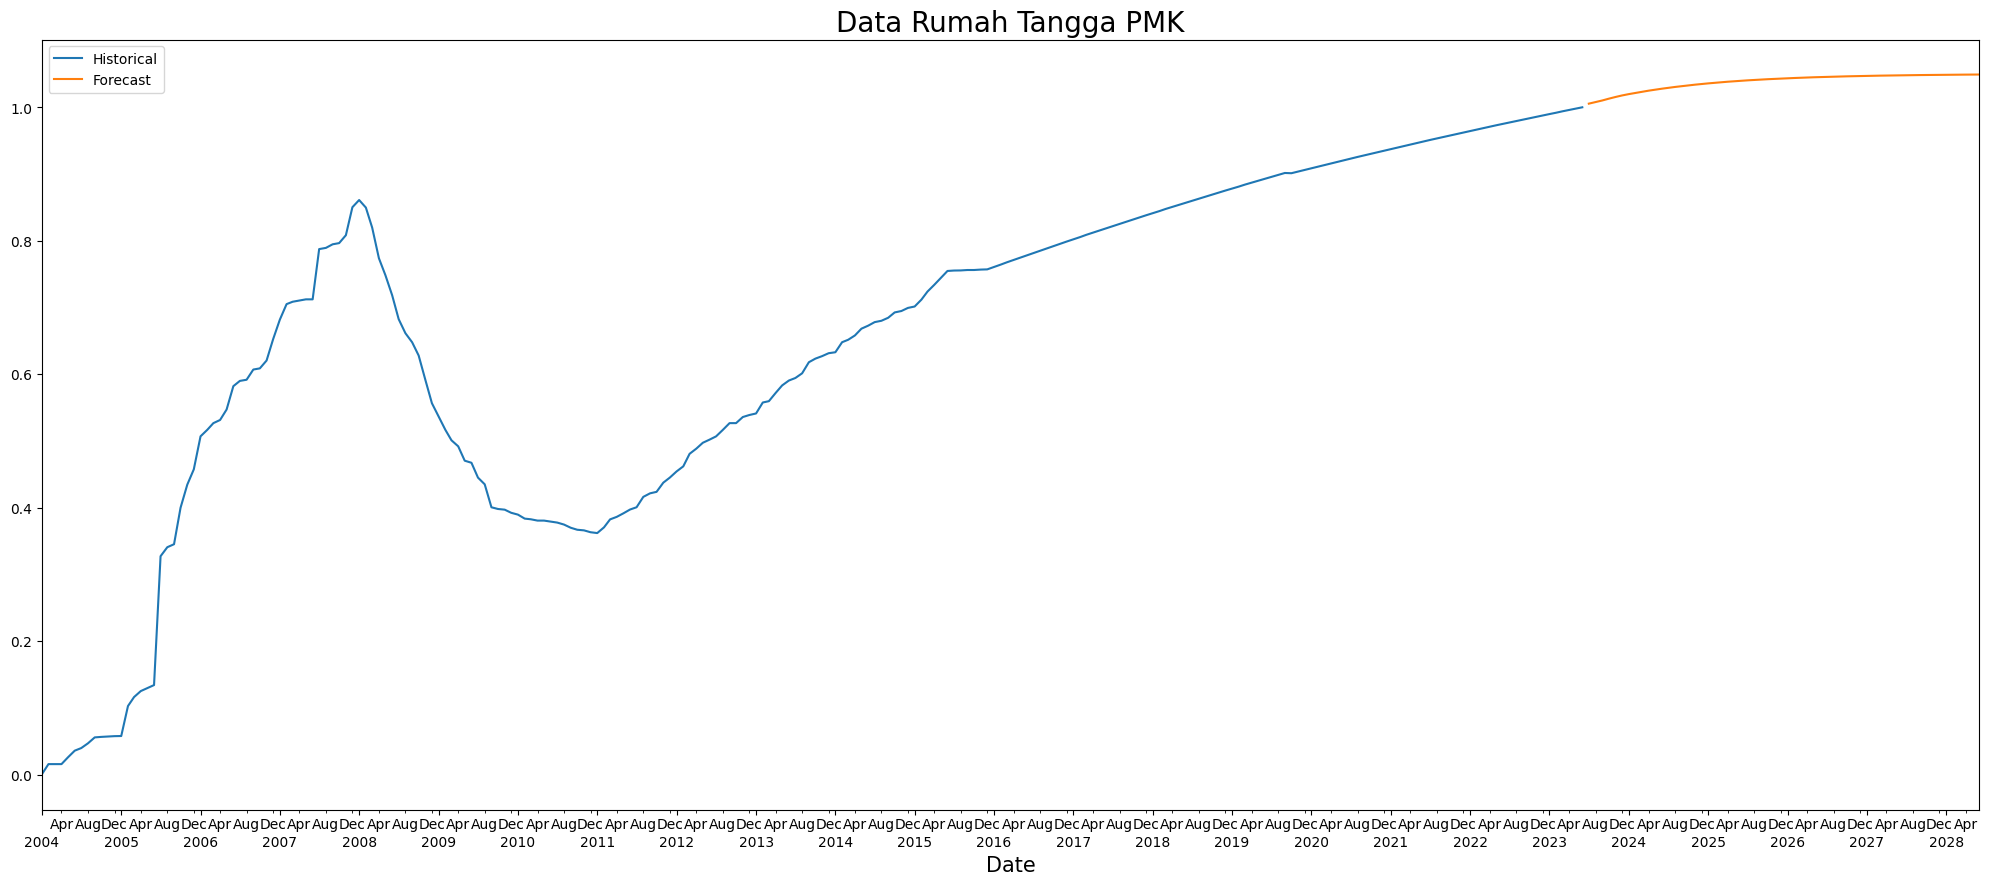

In [147]:
ARIMA_LSTM_forecast = forecast_ARIMA_LSTM(LSTM_weight, ARIMA_weight, ARIMA_forecast, LSTM_forecast)

for region in REGIONS:
    forecast = LSTM_forecast[region]
    forecast = forecast.reset_index()
    forecast.columns = ['Periode', 'Forecast']
    combined_data = combine_data(region, forecast, data)
    visualize(combined_data, var=['Historical', 'Forecast'], label=region)